**This part of the project includes:**

1. Fitting an initial regression model, conducting statistical analyses of the results, taking a look at the p-values of the various features and perform some feature selection. 
2. Testing for regression assumptions including normality, heteroscedasticity, and independence. 
3. From these tests, we'll then refine and improve the model, not just for performance, but for interpretability as well.
4. Improving and deepening our answers to business problems using built models.

**MODEL FITTING & VALIDATION**
**a.	Model Building Summary Steps:**

i.	Perform Stepwise Selection to select for features with p-value < 0.05

ii.	Build the model using statsmodels with the result from stepwise selection and get r2, adjusted r2

1. Predict yhat
2.	Plot yhat regplot
3. Get intercept
4. Get coefficients

iv.	Test initial model

1.	Recheck multicollinearity with heatmap
2.	Recheck residuals normality with qqplot
3.	Recheck residuals homoscedasticity with regplot
4.	K-fold cross-validation

v.	Validate initial model

1.	Train test split and fit the line
2.	Calculate RMSE: very small difference = not overfitted
3.	Plot model residuals vs prediction with regplot
4.	Calculate accuracy percentage
5.	Bias-variance tradeoff

**b.	Models:**

i.	Model A: All features + location

ii.	Model B: All features with outliers (3 STD away) removed + location

iii.Model C: Polynomial Regression on Model A

iv.	Model D: Log transformed all continuous features (not including target ‘price) + all features 

In [714]:
#import all necessary packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
sns.set(style="whitegrid")

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms

import scipy.stats as stats

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import pickle

import warnings
warnings.filterwarnings("ignore")

Recall that there are four main assumptions underlying a linear regression model:

1. **Linearity:** With linear models, the target variable is being modeled as a linear combination of the independent variables. As such, there should be a linear relationship between the target variable and the various features being used. 

2. **Normality:** With linear models, the errors (residuals) from the model are assumed to be normally distributed. A good heuristic to initially check for this is to use a Q-Q plot.

3. **Homoscedasticity:** Along with the assumption of normal distribution, error terms should also not be correlated with the target variable or other features within the model. If errors indeed appear to be random and there are no discernible trends, then the errors are said to be homoscedastic. Looking at a simple plot of residuals against the target variable or other feature is generally sufficient to gauge this.

4. **Independence:** Finally, regression models assume that the various independent features feeding into the model are independent. We will investigate multicollinearity. Multicollinearity is when a variable can be predicted with substantial accuracy by a separate set of features. It's unwise to include two features in a regression model that are highly correlated. This mistake will severely impede interpretation as coefficient weights of the model become unstable so it is difficult or impossible to determine which features are most influential.

In [715]:
#read our dataframe
clean = pd.read_csv('./Data & Figures/clean.csv', index_col = 0)
clean.head()

,price,price_log,sqft_above,sqft_above_log,sqft_lot,sqft_lot_log,sqft_living15,sqft_living15_log,sqft_lot15,age,...,cond_5.0,zip_A,zip_B,zip_C,zip_D,zip_E,zip_F,zip_G,zip_H,zip_I
15937,268950.0,12.502281,880,6.779922,8100,8.999619,1000,6.907755,8100,72,...,0,0,0,0,0,1,0,0,0,0
20963,399900.0,12.898970,900,6.802395,1005,6.912743,1440,7.272398,1188,4,...,0,0,0,0,0,0,0,1,0,0
7614,339000.0,12.733755,720,6.579251,4128,8.325548,1510,7.319865,4538,73,...,0,1,0,0,0,0,0,0,0,0
3257,380000.0,12.847927,840,6.733402,7372,8.905444,1930,7.565275,5150,76,...,1,1,0,0,0,0,0,0,0,0
16723,365000.0,12.807653,1600,7.377759,4168,8.335192,1190,7.081709,4168,88,...,0,1,0,0,0,0,0,0,0,0


In [716]:
clean.columns

Index(['price', 'price_log', 'sqft_above', 'sqft_above_log', 'sqft_lot',
       'sqft_lot_log', 'sqft_living15', 'sqft_living15_log', 'sqft_lot15',
       'age', 'bedrooms', 'bathrooms', 'floors', 'water_1.0', 'base_1.0',
       'reno_1.0', 'cond_2.0', 'cond_3.0', 'cond_4.0', 'cond_5.0', 'zip_A',
       'zip_B', 'zip_C', 'zip_D', 'zip_E', 'zip_F', 'zip_G', 'zip_H', 'zip_I'],
      dtype='object')

### Prepare Continuous Data: Feature Scaling

In [717]:
clean_continuous = clean[['price', 'price_log', 
                          'sqft_above', 'sqft_above_log', 
                          'sqft_lot', 'sqft_lot_log', 
                          'sqft_living15', 'sqft_living15_log', 
                          'sqft_lot15', 
                          'age']]

In [718]:
# normalize (subract mean and divide by std)
def normalize(feature):
    return (feature - feature.mean()) / feature.std()

clean_continuous_norm = clean_continuous.apply(normalize)

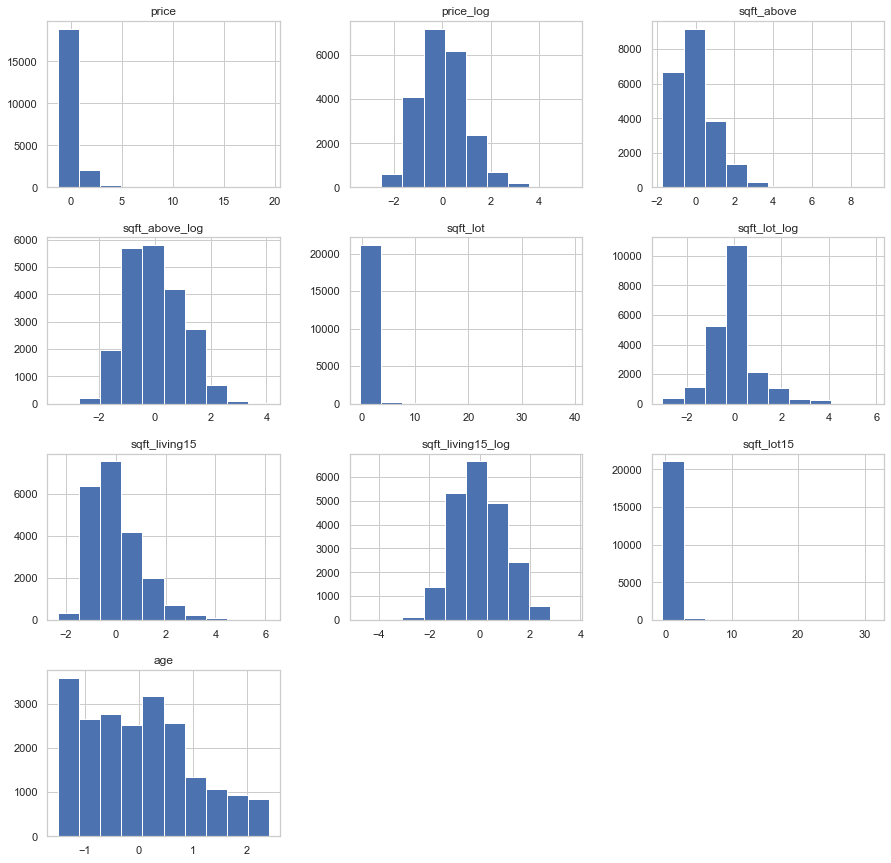

In [719]:
#plot the new normalized data
clean_continuous_norm.hist(figsize = (15, 15));

#save
plt.savefig('./Data & Figures/log_norm_histplot')

In [720]:
#drop old values
clean.drop(['price', 'price_log',
            'sqft_above', 'sqft_above_log',
            'sqft_lot', 'sqft_lot_log',
            'sqft_living15', 'sqft_living15_log',
            'sqft_lot15', 'age'], axis = 1, inplace = True)

In [721]:
#add the newly standardized values
clean = pd.concat([clean, clean_continuous_norm], axis = 1) 

In [722]:
#review
clean.head()

,bedrooms,bathrooms,floors,water_1.0,base_1.0,reno_1.0,cond_2.0,cond_3.0,cond_4.0,cond_5.0,...,price,price_log,sqft_above,sqft_above_log,sqft_lot,sqft_lot_log,sqft_living15,sqft_living15_log,sqft_lot15,age
15937,3,1.00,1.0,0,1,0,0,1,0,0,...,-0.740571,-1.044412,-1.099527,-1.443346,-0.169225,0.011001,-1.441766,-1.932101,-0.170986,0.955962
20963,2,1.75,1.5,0,1,0,0,1,0,0,...,-0.384457,-0.288860,-1.075393,-1.390746,-0.340062,-2.297864,-0.799934,-0.818484,-0.423750,-1.357975
7614,3,1.00,1.0,0,1,0,0,0,1,0,...,-0.550073,-0.603535,-1.292602,-1.913036,-0.264865,-0.734773,-0.697824,-0.673521,-0.301244,0.989991
3257,2,1.00,1.0,0,1,0,0,0,0,1,...,-0.438575,-0.386080,-1.147796,-1.552231,-0.186754,-0.093192,-0.085165,0.075960,-0.278864,1.092076
16723,5,2.00,1.5,0,0,0,0,1,0,0,...,-0.479367,-0.462787,-0.230689,-0.044048,-0.263901,-0.724104,-1.164611,-1.400849,-0.314775,1.500418


# MODEL A: 
## USING STEPWISE SELECTION
## WITH ALL FEATURES (p_value < 0.05) INCLUDED

In [723]:
clean.columns

Index(['bedrooms', 'bathrooms', 'floors', 'water_1.0', 'base_1.0', 'reno_1.0',
       'cond_2.0', 'cond_3.0', 'cond_4.0', 'cond_5.0', 'zip_A', 'zip_B',
       'zip_C', 'zip_D', 'zip_E', 'zip_F', 'zip_G', 'zip_H', 'zip_I', 'price',
       'price_log', 'sqft_above', 'sqft_above_log', 'sqft_lot', 'sqft_lot_log',
       'sqft_living15', 'sqft_living15_log', 'sqft_lot15', 'age'],
      dtype='object')

In [724]:
#including all non-log-transformed features
preprocessed_A = clean[['price', 'sqft_above', 'sqft_lot', 'sqft_living15', 'sqft_lot15',
                      'age', 'bedrooms', 'bathrooms', 'floors', 
                      'water_1.0', 'base_1.0', 'reno_1.0',
                      'cond_2.0', 'cond_3.0', 'cond_4.0', 'cond_5.0',
                      'zip_A', 'zip_B', 'zip_C', 'zip_D', 'zip_E', 'zip_F', 'zip_G', 'zip_H', 'zip_I']]

In [725]:
#review
preprocessed_A.head(2)

,price,sqft_above,sqft_lot,sqft_living15,sqft_lot15,age,bedrooms,bathrooms,floors,water_1.0,...,cond_5.0,zip_A,zip_B,zip_C,zip_D,zip_E,zip_F,zip_G,zip_H,zip_I
15937,-0.740571,-1.099527,-0.169225,-1.441766,-0.170986,0.955962,3,1.00,1.0,0,...,0,0,0,0,0,1,0,0,0,0
20963,-0.384457,-1.075393,-0.340062,-0.799934,-0.423750,-1.357975,2,1.75,1.5,0,...,0,0,0,0,0,0,0,1,0,0


In [726]:
preprocessed_A.shape

(21420, 25)

In [727]:
preprocessed_A.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21420 entries, 15937 to 2495
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21420 non-null  float64
 1   sqft_above     21420 non-null  float64
 2   sqft_lot       21420 non-null  float64
 3   sqft_living15  21420 non-null  float64
 4   sqft_lot15     21420 non-null  float64
 5   age            21420 non-null  float64
 6   bedrooms       21420 non-null  int64  
 7   bathrooms      21420 non-null  float64
 8   floors         21420 non-null  float64
 9   water_1.0      21420 non-null  int64  
 10  base_1.0       21420 non-null  int64  
 11  reno_1.0       21420 non-null  int64  
 12  cond_2.0       21420 non-null  int64  
 13  cond_3.0       21420 non-null  int64  
 14  cond_4.0       21420 non-null  int64  
 15  cond_5.0       21420 non-null  int64  
 16  zip_A          21420 non-null  int64  
 17  zip_B          21420 non-null  int64  
 18  zip

In [728]:
#define X, y training set
X = preprocessed_A.drop(['price'], axis = 1)
y = preprocessed_A['price']

### Perform Stepwise Selection

In [729]:
#perform stepwise selection to ensure that we do not include any features with p-values of above 0.05 (learn.co)
def stepwise_selection(X, y, 
                       initial_list = [], 
                       threshold_in = 0.01, 
                       threshold_out = 0.05, 
                       verbose = True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed = False
        # forward step
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included + [new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed = True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [730]:
#apply function
result_A = stepwise_selection(X, y, verbose = True)
print('Resulting Features:')
print(result_A)

Add  sqft_living15                  with p-value 0.0
Add  zip_A                          with p-value 0.0
Add  bathrooms                      with p-value 0.0
Add  zip_C                          with p-value 0.0
Add  sqft_above                     with p-value 0.0
Add  age                            with p-value 0.0
Add  water_1.0                      with p-value 0.0
Add  base_1.0                       with p-value 8.75145e-194
Add  zip_B                          with p-value 6.9763e-191
Add  bedrooms                       with p-value 6.00824e-95
Add  zip_G                          with p-value 9.03639e-88
Add  zip_F                          with p-value 4.2296e-16
Add  cond_3.0                       with p-value 7.71182e-17
Add  reno_1.0                       with p-value 5.11113e-13
Add  zip_E                          with p-value 5.54062e-09
Add  zip_I                          with p-value 6.78986e-10
Add  cond_5.0                       with p-value 1.06607e-07
Add  floors        

Recall that a common significance cutoff of p-value is 0.05. Our model should eliminate these irrelevant features.

The null hypothesis H0 for multiple regression states that there is no relationship between the chosen features and the target 'price'. All of the above p-values round to 0, which means we can reject H0. All of the p-values indicate that all of the current features are substantially influential.

In [731]:
#check out how many features satisfy p < 0.05
len(result_A)

19

## Build Model A

In [732]:
#build Model A in statsmodels
import statsmodels.api as sm

#interecept is not included by default and should be added manually
X_in = X[result_A]
X_intercept = sm.add_constant(X_in) 

#estimation by ordinary least squares (OLS)
model_A = sm.OLS(y, X_intercept).fit() 

#get summary
model_A.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     2269.
Date:                Wed, 03 Feb 2021   Prob (F-statistic):               0.00
Time:                        00:09:46   Log-Likelihood:                -18575.
No. Observations:               21420   AIC:                         3.719e+04
Df Residuals:                   21400   BIC:                         3.735e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.7156      0.049    -14.539      0.000      -0.812      -0.619
sqft_living15     0.1774      0.006     27.777      0.000       0.165       0.190
zip_A             0.7339      0.014     52.183      0.000       0.706       0.761
bathrooms         0.2142      0.009     23.153      0.000       0.196       0.232
zip_C             0.7859      0.016     49.607      0.000       0.755       0.817
sqft_above        0.5371      0.008     66.059      0.000       0.521       0.553
age               0.1435      0.006     23.171      0.000       0.131       0.156
water_1.0         2.3157      0.049     47.598      0.000       2.220       2.411
base_1.0          0.3287      0.011     31.006      0.000       0.308       0.350
zip_B             0.4750      0.015     31.426      0.000       0.445       0.505
bedrooms         -0.1109      0.006    -20.016      0.000      -0.122      -0.100
zip_G             0.3449      0.017     19.799      0.000       0.311       0.379
zip_F            -0.0820      0.018     -4.681      0.000      -0.116      -0.048
cond_3.0          0.0881      0.043      2.072      0.038       0.005       0.171
reno_1.0          0.1796      0.023      7.858      0.000       0.135       0.224
zip_E             0.1397      0.019      7.297      0.000       0.102       0.177
zip_I             0.1628      0.026      6.293      0.000       0.112       0.214
cond_5.0          0.2497      0.044      5.632      0.000       0.163       0.337
floors           -0.0567      0.011     -5.370      0.000      -0.077      -0.036
cond_4.0          0.1677      0.043      3.931      0.000       0.084       0.251
==============================================================================
Omnibus:                    17979.101   Durbin-Watson:                   1.284
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1611084.563
Skew:                           3.531   Prob(JB):                         0.00
Kurtosis:                      44.896   Cond. No.                         99.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

* p-value of 0 which rejects the null hypothesis.
* Additionally, the kurtosis is > 3, indicating heavier tails than a normal distribution. 
* The skewness value of 3.5 shows that underlying data is not symmetrical. 

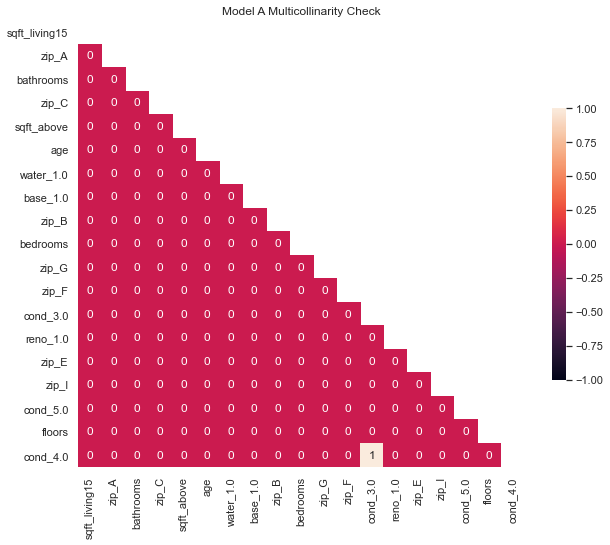

In [733]:
#recheck for multicollinearity
mask = np.zeros_like(abs(X[result_A].corr()) > 0.75)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize = (10, 10))
    ax = sns.heatmap(abs(X[result_A].corr()) > 0.75, 
                     annot = True, 
                     ax = ax, 
                     cbar_kws = {"shrink": .5}, 
                     mask = mask, 
                     vmax = 1,
                     vmin = -1,
                     square = True)
    plt.title('Model A Multicollinarity Check')
plt.savefig('./Data & Figures/model_A_multicollinarity_check')

In [734]:
#drop 'cond_4.0' to avoid multicollinearity
preprocessed_A.drop('cond_4.0', axis = 1, inplace = True)

In [735]:
#redefine X, y training set
X = preprocessed_A.drop(['price'], axis = 1)
y = preprocessed_A['price']

In [736]:
#redo stepwise selection
result_A = stepwise_selection(X, y, verbose = True)
print('Resulting Features:')
print(result_A)

Add  sqft_living15                  with p-value 0.0
Add  zip_A                          with p-value 0.0
Add  bathrooms                      with p-value 0.0
Add  zip_C                          with p-value 0.0
Add  sqft_above                     with p-value 0.0
Add  age                            with p-value 0.0
Add  water_1.0                      with p-value 0.0
Add  base_1.0                       with p-value 8.75145e-194
Add  zip_B                          with p-value 6.9763e-191
Add  bedrooms                       with p-value 6.00824e-95
Add  zip_G                          with p-value 9.03639e-88
Add  zip_F                          with p-value 4.2296e-16
Add  cond_3.0                       with p-value 7.71182e-17
Add  reno_1.0                       with p-value 5.11113e-13
Add  zip_E                          with p-value 5.54062e-09
Add  zip_I                          with p-value 6.78986e-10
Add  cond_5.0                       with p-value 1.06607e-07
Add  floors        

In [737]:
#rebuild Model A
import statsmodels.api as sm

#interecept is not included by default and should be added manually
X_in = X[result_A]
X_intercept = sm.add_constant(X_in) 

#estimation by ordinary least squares (OLS)
model_A = sm.OLS(y, X_intercept).fit() 

#get summary
model_A.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     2268.
Date:                Wed, 03 Feb 2021   Prob (F-statistic):               0.00
Time:                        00:09:50   Log-Likelihood:                -18578.
No. Observations:               21420   AIC:                         3.720e+04
Df Residuals:                   21400   BIC:                         3.736e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.5501      0.028    -19.884      0.000      -0.604      -0.496
sqft_living15     0.1772      0.006     27.739      0.000       0.165       0.190
zip_A             0.7337      0.014     52.164      0.000       0.706       0.761
bathrooms         0.2142      0.009     23.157      0.000       0.196       0.232
zip_C             0.7859      0.016     49.600      0.000       0.755       0.817
sqft_above        0.5373      0.008     66.073      0.000       0.521       0.553
age               0.1431      0.006     23.120      0.000       0.131       0.155
water_1.0         2.3150      0.049     47.575      0.000       2.220       2.410
base_1.0          0.3292      0.011     31.052      0.000       0.308       0.350
zip_B             0.4748      0.015     31.407      0.000       0.445       0.504
bedrooms         -0.1107      0.006    -19.977      0.000      -0.122      -0.100
zip_G             0.3447      0.017     19.784      0.000       0.311       0.379
zip_F            -0.0821      0.018     -4.685      0.000      -0.116      -0.048
cond_3.0         -0.0780      0.010     -7.753      0.000      -0.098      -0.058
reno_1.0          0.1798      0.023      7.865      0.000       0.135       0.225
zip_E             0.1390      0.019      7.259      0.000       0.101       0.176
zip_I             0.1622      0.026      6.268      0.000       0.111       0.213
cond_5.0          0.0838      0.016      5.160      0.000       0.052       0.116
floors           -0.0569      0.011     -5.387      0.000      -0.078      -0.036
cond_2.0         -0.1352      0.046     -2.937      0.003      -0.225      -0.045
==============================================================================
Omnibus:                    17964.927   Durbin-Watson:                   1.284
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1607735.037
Skew:                           3.527   Prob(JB):                         0.00
Kurtosis:                      44.853   Cond. No.                         56.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [738]:
#create linear regression object
linreg = LinearRegression()

#fit model
linreg.fit(X[result_A], y)

#predict yhat using our model
yhat = linreg.predict(X[result_A])
yhat

array([-1.04396899, -0.79988517, -0.33824057, ..., -0.71789283,
       -0.34289998, -0.52898149])

In [739]:
#get intercept
linreg.intercept_

-0.5501355394147057

In [740]:
#get coefficients and sort them
coefficients_A = dict(zip(X[result_A], list(linreg.coef_)))
dict(sorted(coefficients_A.items(), key = lambda item: item[1]))

{'cond_2.0': -0.13523211025571027,
 'bedrooms': -0.11066913362648324,
 'zip_F': -0.08210151123051022,
 'cond_3.0': -0.07800378763802561,
 'floors': -0.05685379780858873,
 'cond_5.0': 0.0837654415691999,
 'zip_E': 0.13896434716421477,
 'age': 0.14314370392407472,
 'zip_I': 0.16220670743991467,
 'sqft_living15': 0.17720665726244736,
 'reno_1.0': 0.17982888317665457,
 'bathrooms': 0.21423240143100816,
 'base_1.0': 0.3292482733084546,
 'zip_G': 0.34465306006076707,
 'zip_B': 0.47483510890551517,
 'sqft_above': 0.537288277093439,
 'zip_A': 0.7337234937057016,
 'zip_C': 0.7858900555592186,
 'water_1.0': 2.314977026777235}

In [741]:
!pip install waterfallcharts
!pip install plotly==4.14.3
import waterfall_chart
import plotly.graph_objects as go

In [742]:
lists_A = sorted(coefficients_A.items(), key = lambda item: item[1])
a, b = zip(*lists_A)
fig = go.Figure(go.Waterfall(x  = a, y = b, 
                             name = "coefficients"))
fig.update_layout(title = 'Model A Coefficients',
                  showlegend = True)
fig.update_xaxes(title_text = 'Features', tickangle = 90)
fig.update_yaxes(title_text = 'Coefficients')
fig.show()
#fig.write_image('./Data & Figures/model_A_waterfall.png')

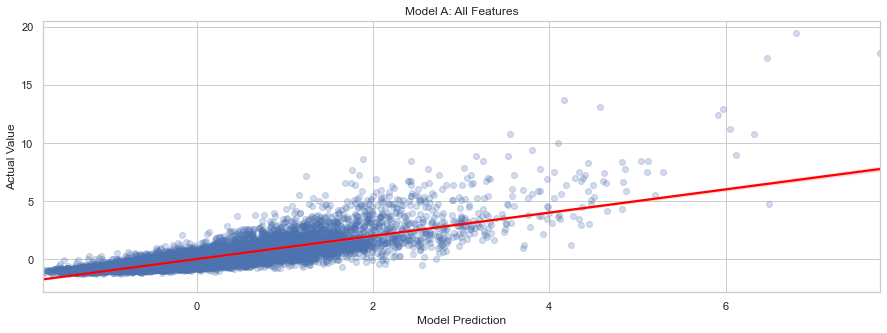

In [743]:
#plot y_hat
plt.figure(figsize = (15, 5))
sns.regplot(yhat, y, 
            line_kws = {'color': 'red'},
            scatter_kws = {'color':'b','alpha':0.25},color='r')
plt.title('Model A: All Features')
plt.xlabel('Model Prediction')
plt.ylabel('Actual Value');
plt.savefig('./Data & Figures/model_A_regplot')

## Rank Features for Model A

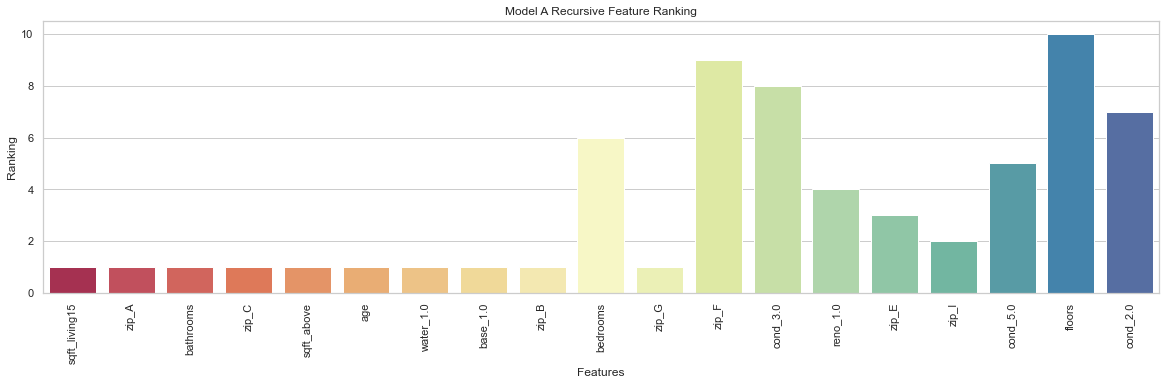

<Figure size 432x288 with 0 Axes>

In [744]:
linreg = LinearRegression()

#set number of features to be 10
selector = RFE(linreg, n_features_to_select = 10) 

#convert y to 1d np array to prevent DataConversionWarning
selector = selector.fit(X[result_A], y.values.ravel()) 
selector.support_

#plot features ranking
plt.figure(figsize = (20, 5))
sns.barplot(x = X[result_A].columns, y = selector.ranking_, palette = 'Spectral');
plt.title('Model A Recursive Feature Ranking')
plt.xlabel('Features')
plt.ylabel('Ranking')
plt.xticks(rotation = 90)
plt.show()
plt.savefig('./Data & Figures/model_A_recursive_features_elimination')

## Test Model A

**Recheck for multicollinearity**

The Variance Inflation Factor (VIF) is a measure of colinearity among predictor variables (features X) within a multiple regression. It is calculated by taking the the ratio of the variance of all a given model's betas divide by the variane of a single beta if it were fit alone.

VIF quantifies how much the variance is inflated.

In [745]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 

#recheck for multicollinearity
vif = [variance_inflation_factor(X[result_A].values, i) for i in range(X[result_A].shape[1])] 
list(zip(result_A, vif))

[('sqft_living15', 2.6318276577199327),
 ('zip_A', 4.290652617544419),
 ('bathrooms', 24.5808924376999),
 ('zip_C', 1.824919485985968),
 ('sqft_above', 3.148057722816477),
 ('age', 2.2423648207258178),
 ('water_1.0', 1.0400373391710502),
 ('base_1.0', 2.7822492090783775),
 ('zip_B', 1.8220859772868632),
 ('bedrooms', 17.341313318594572),
 ('zip_G', 1.5956441254772724),
 ('zip_F', 1.459053857213612),
 ('cond_3.0', 4.023563239782993),
 ('reno_1.0', 1.1559974679711245),
 ('zip_E', 1.4476228181714277),
 ('zip_I', 1.179919990138253),
 ('cond_5.0', 1.3350267944167478),
 ('floors', 14.997470031513634),
 ('cond_2.0', 1.0299440989722572)]

While the p-values indicate that all of the current features are impactful, the variance inflation factor indicates that there is moderate multicollinearity between our variables.  A rule of thumb commonly used in practice is if a VIF is > 10, we have high multicollinearity, and the parameter estimates will have large standard errors because of this. We see here those 'problematic' features are:

* 'cond_3.0', 23.10854748754023
* 'floors', 17.115709258109163

Let's recheck for multicollinearity.

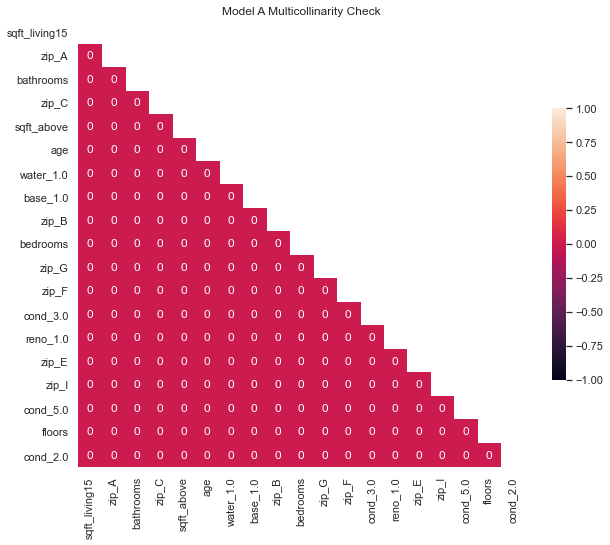

In [746]:
#recheck for multicollinearity
mask = np.zeros_like(abs(X[result_A].corr()) > 0.75)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize = (10, 10))
    ax = sns.heatmap(abs(X[result_A].corr()) > 0.75, 
                     annot = True, 
                     ax = ax, 
                     cbar_kws = {"shrink": .5}, 
                     mask = mask, 
                     vmax = 1,
                     vmin = -1,
                     square = True)
    plt.title('Model A Multicollinarity Check')
plt.savefig('./Data & Figures/model_A_multicollinarity_check')

**Recheck for normality**

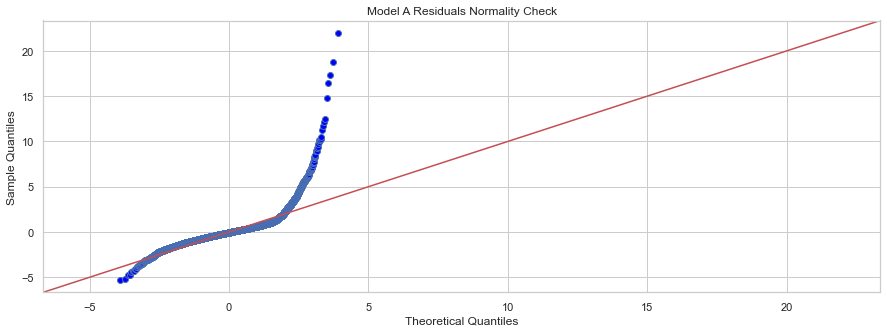

<Figure size 432x288 with 0 Axes>

In [747]:
#recheck for normality
fig = sm.graphics.qqplot(model_A.resid, 
                         dist = stats.norm, 
                         line = '45', 
                         fit = True)
fig.set_size_inches(15, 5)
plt.title('Model A Residuals Normality Check')
plt.show()
plt.savefig('./Data & Figures/model_A_residuals_qqplot')

**Recheck for homoscedasticity**

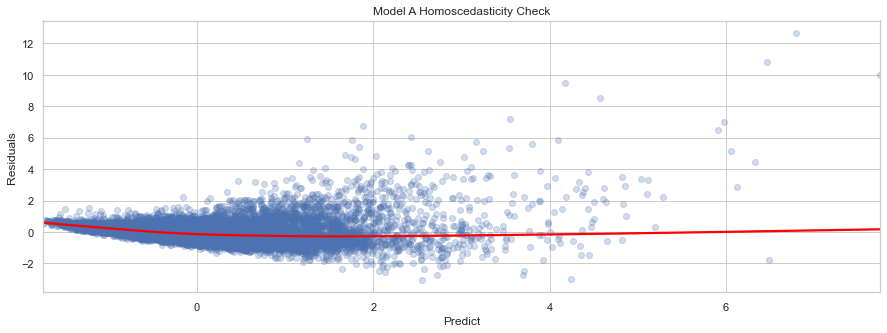

<Figure size 432x288 with 0 Axes>

In [748]:
#recheck for homoscedasticity
plt.figure(figsize = (15, 5))
sns.regplot(x = model_A.predict(), 
            y = model_A.resid, 
            lowess = True, 
            line_kws = {'color': 'red'},
            scatter_kws = {'color':'b','alpha':0.25})
plt.title('Model A Homoscedasticity Check')
plt.xlabel('Predict')
plt.ylabel('Residuals')
plt.show()
plt.savefig('./Data & Figures/model_A_homoscedasticity_regplot')

In [749]:
#Goldfeld-Quandt test
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(model_A.resid, model_A.model.exog)
list(zip(name, test))

[('F statistic', 1.0157928175913467), ('p-value', 0.20896254809615292)]

**Recheck for overfitting: K-Fold Cross Validation**

In [750]:
#cross-validation to check for overfitting
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score

linreg = LinearRegression()

#get the mean squared error
mse = make_scorer(mean_squared_error)

cv_result = cross_val_score(linreg, X[result_A], y, cv = 10, scoring = 'neg_mean_squared_error')
cv_result

array([-0.44700717, -0.21879602, -0.29045251, -0.41047355, -0.31343039,
       -0.32220144, -0.30670357, -0.34794801, -0.40046316, -0.31142486])

In [751]:
#the accuracy of the model is the average of the accuracy of each fold
cv_result.mean()

-0.3368900678543956

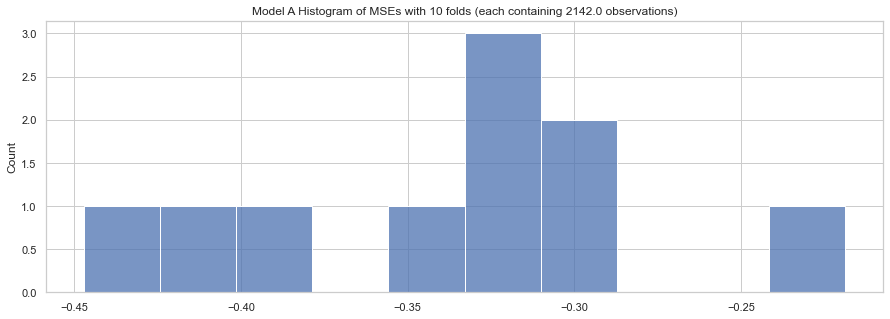

In [752]:
#visualize the cv_result
folds = 10
plt.figure(figsize = (15, 5))
sns.histplot(cv_result, bins = 10);
plt.title('Model A Histogram of MSEs with {} folds (each containing {} observations)'
          .format(folds, round(len(preprocessed_A) / folds, 0)));
plt.savefig('./Data & Figures/model_A_cv_result_histplot')

Our regression visualization suggests that there are some splits for which our fitted model performs significantly less well.

## Validate Model A

In order to get a good sense of how well our model will be doing on new instances, we'll have to perform a so-called "train-test-split". What we'll be doing here, is take a sample of the data that serves as input to "train" our model - fit a linear regression and compute the parameter estimates for our variables, and calculate how well our predictive performance is doing comparing the actual targets y and the fitted yhat obtained by our model.

* Underfitting happens when a model cannot learn the training data, nor can it generalize to new data.
* Overfitting happens when a model learns the training data too well. In fact, so well that it is not generalizeable to new data

In [753]:
#split the data into training and test sets. Use the default split size
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X[result_A], y, test_size = 0.2, random_state = 42)
print(len(X_train), len(y_train), len(X_test), len(y_test))

17136 17136 4284 4284


In [754]:
#import and initialize the linear regression model class
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()

#fit the model to train data
linreg.fit(X_train, y_train)

#calculate predictions on training and test sets
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

To evaluate the model, we compare our predicted values, yhat with the actual value 𝑦 . The difference between the two values is referred to as the residuals. We'll compare our residuals for both test set and training set. To get a summarized measure over all the instances in the test set and training set, a popular metric is the RME (Root Mean Squared Error). A big difference in value between the test and training set (R)MSE is an indication of overfitting.

In [755]:
#calculate residuals (prediction - actual error)
train_residual = y_hat_train - y_train
test_residual = y_hat_test - y_test

In [756]:
#calculate training and test MSE
from sklearn.metrics import mean_squared_error

train_rmse = mean_squared_error(y_train, y_hat_train, squared = False)
test_rmse = mean_squared_error(y_test, y_hat_test, squared = False)

print(train_rmse)
print(test_rmse)

0.5625265909631905
0.6286713292932756


Our (R)MSE of train set and test set are quite similar, we  did not overfit the model.

In [757]:
#get accuracy percentage
accuracy = linreg.score(X_test, y_test)
'Accuracy: {}%'.format(int(round(accuracy * 100)))

'Accuracy: 66%'

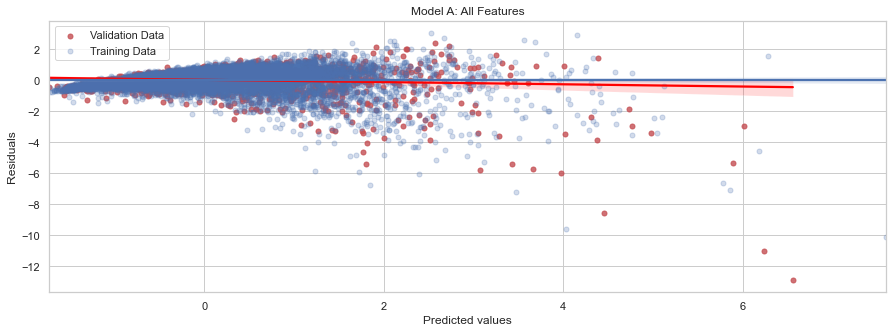

<Figure size 432x288 with 0 Axes>

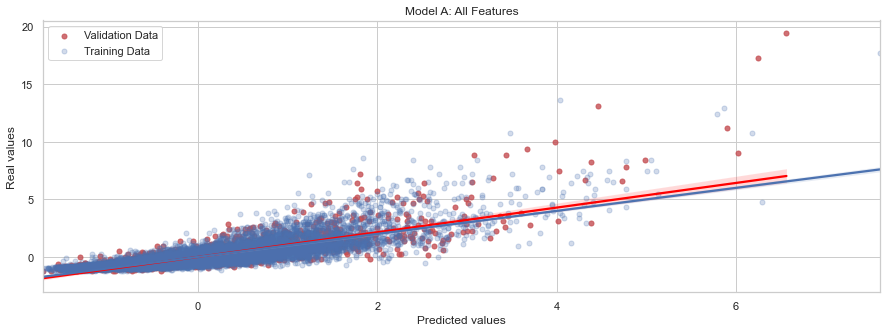

<Figure size 432x288 with 0 Axes>

In [758]:
#plot residuals: 
plt.figure(figsize = (15, 5))
sns.regplot(x = y_hat_test, y = y_hat_test - y_test,
            scatter_kws = {'s': 25}, 
            line_kws = {'color': 'red'},
            color = 'r',
            fit_reg = True, label = 'Validation Data')
sns.regplot(x = y_hat_train, y = y_hat_train - y_train,
            scatter_kws = {'s': 25,'alpha': 0.25}, 
            fit_reg = True, label = 'Training Data')


plt.title('Model A: All Features')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc = 'upper left')
plt.show()
plt.savefig('./Data & Figures/model_B_residuals_regplot')

#plot predictions
plt.figure(figsize = (15, 5))
sns.regplot(x = y_hat_test, y = y_test,
            scatter_kws = {'s': 25}, 
            line_kws = {'color': 'red'}, 
            color = 'r',
            fit_reg = True, label = 'Validation Data')
sns.regplot(x = y_hat_train, y = y_train,
            scatter_kws = {'s': 25,'alpha':0.25}, 
            fit_reg = True, label = 'Training Data')

plt.title('Model A: All Features')
plt.xlabel('Predicted values')
plt.ylabel('Real values')
plt.legend(loc = 'upper left')
plt.show()
plt.savefig('./Data & Figures/model_B_predictions_regplot')

**Bias-Variance Tradeoff**

* Bias arises when wrong assumptions are made when training a model. For example, an interaction effect is missed, or we didn't catch a certain polynomial relationship. Because of this, our algorithm misses the relevant relations between predictors and the target variable. Note how this is similar to underfitting!

* Variance arises when a model is too sensitive to small fluctuations in the training set. When variance is high, random noise in the training data is modeled, rather than the intended outputs. This is overfitting!

The balance between bias and variance is a trade-off. We can reduce the variance but then there is a risk of running a bigger bias, and vice versa. Bias is usually associated with low model complexity, variance with high model complexity. There is generally a "sweet spot" in-between, compromising between bias and variance.

In [759]:
#transform with MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

#scale the train set
X_train_scaled = scaler.fit_transform(X_train)

#scale the test set
X_test_scaled = scaler.transform(X_test)

In [760]:
#training set predictions
lm_train_predictions = linreg.predict(X_train_scaled)

# Test set predictions 
lm_test_predictions = linreg.predict(X_test_scaled)

In [761]:
#function bias() to calculate the bias of a model's predictions given the actual data
def bias(y, y_hat):
    return np.mean(y_hat - y)

#function variance() to calculate the variance of a model's predictions
def variance(y_hat):
    return np.mean([yi**2 for yi in y_hat]) - np.mean(y_hat)**2

In [762]:
#bias and variance for training set 
b_train = bias(y_train, lm_train_predictions) 
v_train = variance(lm_train_predictions) 
print('Train bias: {} \nTrain variance: {}'.format(b_train, v_train))

Train bias: 0.18664386951242035 
Train variance: 0.21068111996219863


In [763]:
#bias and variance for test set 
b_test = bias(y_test, lm_test_predictions) 
v_test = variance(lm_test_predictions) 
print('Test bias: {} \nTest variance: {}'.format(b_test, v_test))

Test bias: 0.17987848096082015 
Test variance: 0.2052605814854409


In [764]:
import pickle

#save model
tuple_objects = (linreg, X_train, y_train)
pickle.dump(tuple_objects, open('./Data & Figures/model_A.pkl','wb'))

In [765]:
#summary table
summary_table_1 = pd.DataFrame({'Model': [], 'Description':[], ' Num Features' : [], 
                                'r2': [], 'Accuracy':[], 
                                'RMSE Train': [], 'RMSE Test': [],
                                'Bias Train': [], 'Bias Test': [], 'Variance Train': [], 'Variance Test': [],
                                'Cross Validation': [],
                                'Multicollinearity': [], 'Normality': [], 'Homoscedasticity': []})
summary_table_1.loc[0] = ['Model A', 'All features', len(result_A), 
                          r2_score(y, yhat), accuracy * 100, 
                          train_rmse, test_rmse,
                          b_train, b_test, v_train, v_test,
                          cv_result.mean(),
                          'P', 'F', 'F']
summary_table_1.head()

,Model,Description,Num Features,r2,Accuracy,RMSE Train,RMSE Test,Bias Train,Bias Test,Variance Train,Variance Test,Cross Validation,Multicollinearity,Normality,Homoscedasticity
0,Model A,All features,19.0,0.668177,66.236718,0.562527,0.628671,0.186644,0.179878,0.210681,0.205261,-0.33689,P,F,F


# MODEL B 
## REMOVE OUTLIERS THAT ARE 3 STD AWAY FROM THE MEAN

In [766]:
#review
preprocessed_A.columns

Index(['price', 'sqft_above', 'sqft_lot', 'sqft_living15', 'sqft_lot15', 'age',
       'bedrooms', 'bathrooms', 'floors', 'water_1.0', 'base_1.0', 'reno_1.0',
       'cond_2.0', 'cond_3.0', 'cond_5.0', 'zip_A', 'zip_B', 'zip_C', 'zip_D',
       'zip_E', 'zip_F', 'zip_G', 'zip_H', 'zip_I'],
      dtype='object')

In [767]:
#removie outliers in 'bedrooms'
count = 0
bedrooms_outliers = []
mean = np.mean(preprocessed_A['bedrooms'])
std = np.std(preprocessed_A['bedrooms'])
cut_off = np.std(preprocessed_A['bedrooms']) * 3 

for idx, row in preprocessed_A['bedrooms'].T.iteritems():
    if abs(row - mean) >= cut_off:
        count += 1
        preprocessed_A.drop(idx, inplace = True)
count

61

In [768]:
#removie outliers in 'bathrooms'
count = 0
bathrooms_outliers = []
mean = np.mean(preprocessed_A['bathrooms'])
std = np.std(preprocessed_A['bathrooms'])
cut_off = np.std(preprocessed_A['bathrooms']) * 3 

for idx, row in preprocessed_A['bathrooms'].T.iteritems():
    if abs(row - mean) >= cut_off:
        count += 1
        preprocessed_A.drop(idx, inplace = True)
count

171

In [769]:
#create new dataframe excluding outliers
preprocessed_B = preprocessed_A[['price', 'sqft_above', 'sqft_lot', 'sqft_living15', 'sqft_lot15', 
                                 'age', 'bedrooms', 'bathrooms', 'floors', 
                                 'water_1.0', 'base_1.0', 'reno_1.0',
                                 'cond_2.0', 'cond_3.0', 'cond_5.0', 
                                 'zip_A', 'zip_B', 'zip_C', 'zip_D', 'zip_E', 'zip_F', 'zip_G', 'zip_H', 'zip_I']]

In [770]:
X = preprocessed_B.drop(['price'], axis = 1)
y = preprocessed_B['price']

## RECURSIVE FEATURE RANKING

Stepwise Selection selects features based on p-value. RFE ranks the variable on the basis on linear regression fit.
By combining them, we select for the 10 most important features.

RFE is effective at selecting those features in a training dataset that are more or most relevant in predicting the target variable.

RFE assigns weights to features (e.g., the coefficients of a linear model), the goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through any specific attribute or callable. Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

In [771]:
#apply stepwise function
result_B = stepwise_selection(X, y, verbose=True)
print('Resulting Features:')
print(result_B)

Add  sqft_living15                  with p-value 0.0
Add  zip_A                          with p-value 0.0
Add  zip_C                          with p-value 0.0
Add  bathrooms                      with p-value 0.0
Add  sqft_above                     with p-value 0.0
Add  water_1.0                      with p-value 0.0
Add  age                            with p-value 9.02849e-269
Add  zip_B                          with p-value 2.01513e-234
Add  base_1.0                       with p-value 6.93761e-183
Add  zip_G                          with p-value 1.73556e-123
Add  bedrooms                       with p-value 2.48146e-67
Add  zip_F                          with p-value 9.25559e-21
Add  cond_3.0                       with p-value 5.63341e-20
Add  reno_1.0                       with p-value 5.59952e-18
Add  zip_E                          with p-value 3.741e-12
Add  zip_I                          with p-value 6.77894e-15
Add  cond_5.0                       with p-value 6.35801e-12
Add  sqft

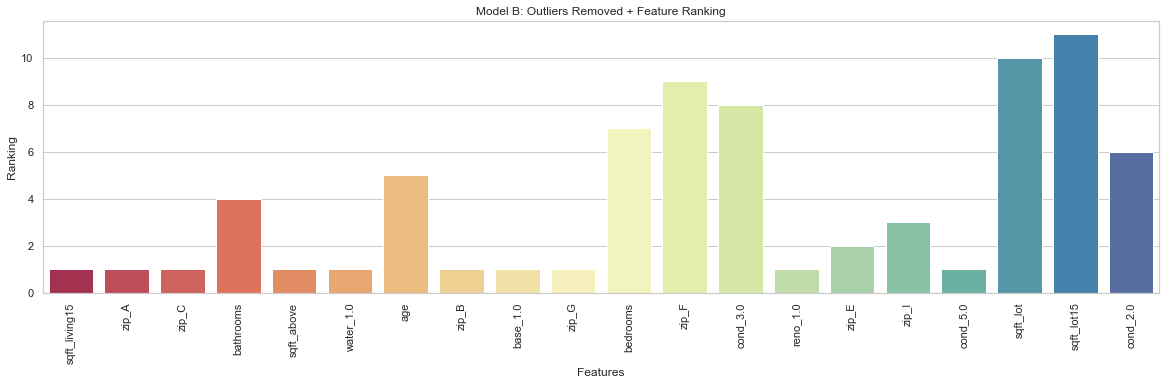

<Figure size 432x288 with 0 Axes>

In [772]:
#feature ranking with recursive feature elimination
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()

#set number of features to be 10
selector = RFE(linreg, n_features_to_select = 10) 

#convert y to 1d np array to prevent DataConversionWarning
selector = selector.fit(X[result_B], y.values.ravel()) 
selector.support_

#plot features ranking
plt.figure(figsize = (20, 5))
sns.barplot(x = X[result_B].columns, y = selector.ranking_, palette = 'Spectral');
plt.title('Model B: Outliers Removed + Feature Ranking')
plt.xlabel('Features')
plt.ylabel('Ranking')
plt.xticks(rotation = 90)
plt.show()
plt.savefig('./Data & Figures/model_B_recursive_features_elimination')

We can see here that the best predictors/ features are 

* 'sqft_living15'
* 'sqft_above'
* 'water_1.0'
* 'base_1.0'
* 'reno_1.0'
* 'cond_5.0'
* 'zip_A'
* 'zip_C'
* 'zip_B'
* 'zip_G'

In [773]:
#fit the linear regression model again using the selected columns
selected_features = X[result_B].columns[selector.support_ ]

linreg.fit(X[selected_features], y)

LinearRegression()

In [774]:
#get intercept
linreg.intercept_

-0.6349657945880702

In [775]:
#get coefficients and sort them
coefficients_B = dict(zip(X[selected_features], list(linreg.coef_)))
dict(sorted(coefficients_B.items(), key = lambda item: item[1]))

{'sqft_living15': 0.21968960631806678,
 'cond_5.0': 0.22946359575498299,
 'zip_G': 0.32740052277666737,
 'reno_1.0': 0.33269675020184486,
 'base_1.0': 0.34022086866986695,
 'sqft_above': 0.4496375425627217,
 'zip_B': 0.4614148154974268,
 'zip_C': 0.746503776547448,
 'zip_A': 0.7706373196540325,
 'water_1.0': 2.1694931096225276}

In [776]:
lists_B = sorted(coefficients_B.items(), key = lambda item: item[1])
a, b = zip(*lists_B)
fig = go.Figure(go.Waterfall(x  = a, y = b, 
                             name = "coefficients"))
fig.update_layout(title = 'Model B Coefficients',
                  showlegend = True)
fig.update_xaxes(title_text = 'Features', tickangle = 90)
fig.update_yaxes(title_text = 'Coefficients')
fig.show()
#fig.write_image('./Data & Figures/model_B_waterfall.png')

## Build Model B

In [777]:
#build model B 
#interecept is not included by default and should be added manually
X_in = X[selected_features]
X_intercept = sm.add_constant(X_in) 

#estimation by ordinary least squares (OLS)
model_B = sm.OLS(y, X_intercept).fit() 

#get summary
model_B.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.643
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     3811.
Date:                Wed, 03 Feb 2021   Prob (F-statistic):               0.00
Time:                        00:10:18   Log-Likelihood:                -16842.
No. Observations:               21188   AIC:                         3.371e+04
Df Residuals:                   21177   BIC:                         3.379e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.6350      0.007    -89.647      0.000      -0.649      -0.621
sqft_living15     0.2197      0.006     36.156      0.000       0.208       0.232
zip_A             0.7706      0.009     81.403      0.000       0.752       0.789
zip_C             0.7465      0.013     57.550      0.000       0.721       0.772
sqft_above        0.4496      0.006     72.821      0.000       0.438       0.462
water_1.0         2.1695      0.047     46.069      0.000       2.077       2.262
zip_B             0.4614      0.012     37.873      0.000       0.438       0.485
base_1.0          0.3402      0.008     40.289      0.000       0.324       0.357
zip_G             0.3274      0.015     22.401      0.000       0.299       0.356
reno_1.0          0.3327      0.021     16.229      0.000       0.293       0.373
cond_5.0          0.2295      0.014     16.593      0.000       0.202       0.257
==============================================================================
Omnibus:                    13050.428   Durbin-Watson:                   1.154
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           311682.621
Skew:                           2.544   Prob(JB):                         0.00
Kurtosis:                      21.087   Cond. No.                         16.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

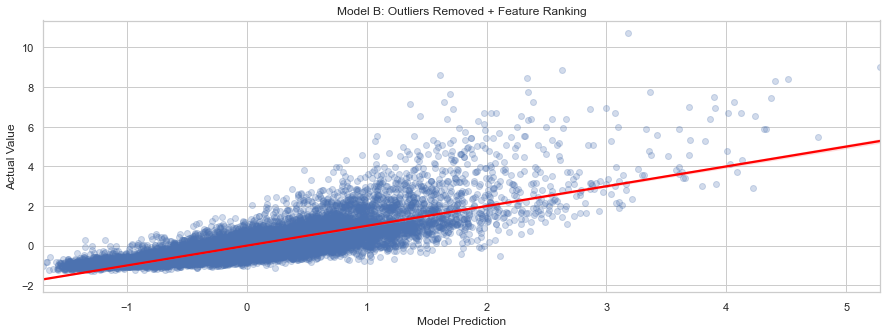

In [778]:
#predict yhat using our model
yhat = linreg.predict(X[selected_features])
yhat

#plot y_hat
plt.figure(figsize = (15, 5))
sns.regplot(yhat, y, 
            line_kws = {'color': 'red'},
            scatter_kws = {'color':'b','alpha':0.25},color='r')
plt.title('Model B: Outliers Removed + Feature Ranking')
plt.xlabel('Model Prediction')
plt.ylabel('Actual Value');
plt.savefig('./Data & Figures/model_B_regplot')

## Test Model B

In [779]:
#recheck for multicollinearity
vif = [variance_inflation_factor(X[selected_features].values, i) for i in range(X[selected_features].shape[1])] 
list(zip(selected_features, vif))

[('sqft_living15', 2.519508089485655),
 ('zip_A', 1.5919288487173633),
 ('zip_C', 1.1511314313714078),
 ('sqft_above', 2.4906156861493094),
 ('water_1.0', 1.0169832185601877),
 ('zip_B', 1.0945575208882412),
 ('base_1.0', 1.817036828474217),
 ('zip_G', 1.0833801992863918),
 ('reno_1.0', 1.0483186572933074),
 ('cond_5.0', 1.1057041597037989)]

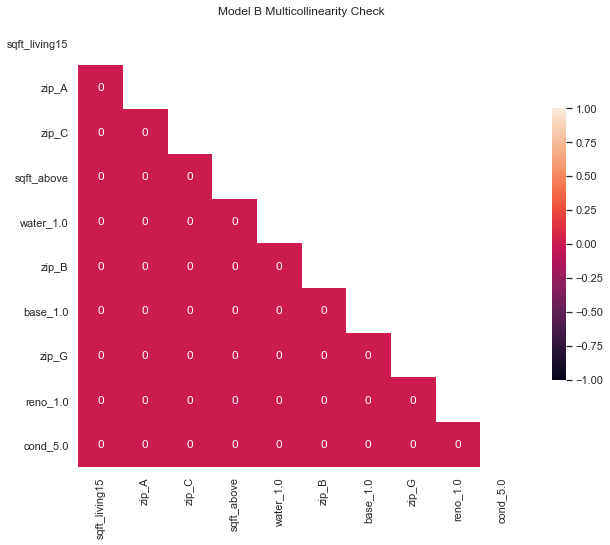

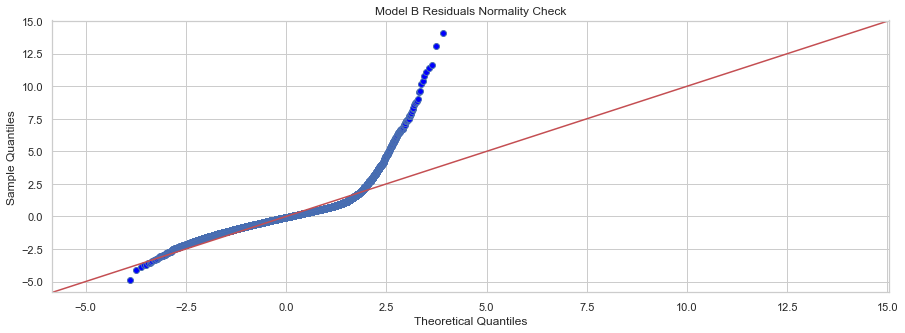

<Figure size 432x288 with 0 Axes>

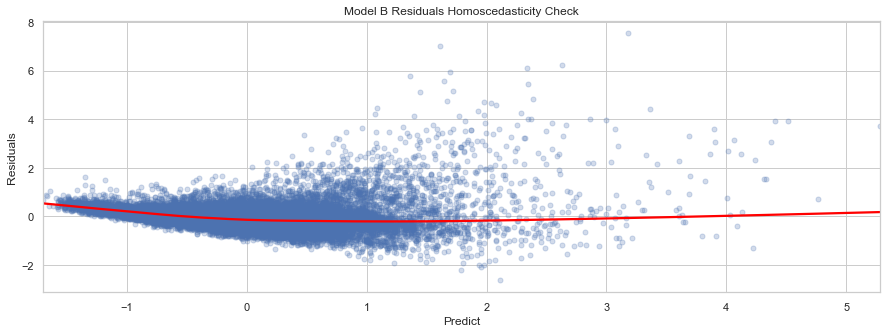

<Figure size 432x288 with 0 Axes>

In [780]:
#recheck for multicollinearity
mask = np.zeros_like(abs(X[selected_features].corr()) > 0.75)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize = (10, 10))
    ax = sns.heatmap(abs(X[selected_features].corr()) > 0.75, 
                     annot = True, 
                     ax = ax, 
                     cbar_kws = {"shrink": .5}, 
                     mask = mask, 
                     vmax = 1,
                     vmin = -1,
                     square = True)
    plt.title('Model B Multicollinearity Check')
plt.savefig('./Data & Figures/model_B_multicollinarity_check')

#recheck for normality
fig = sm.graphics.qqplot(model_B.resid, 
                         dist = stats.norm, 
                         line = '45', 
                         fit = True)
fig.set_size_inches(15, 5)
plt.title('Model B Residuals Normality Check')
plt.show()
plt.savefig('./Data & Figures/model_B_residuals_qqplot')

#recheck for homoscedasticity
plt.figure(figsize = (15, 5))
sns.regplot(x = model_B.predict(), 
            y = model_B.resid, 
            lowess = True, 
            line_kws = {'color': 'red'},
            scatter_kws = {'s': 25,'alpha': 0.25})
plt.title('Model B Residuals Homoscedasticity Check')
plt.xlabel('Predict')
plt.ylabel('Residuals')
plt.show()
plt.savefig('./Data & Figures/model_B_homoscedasticity_regplot')

In [781]:
#Goldfeld-Quandt test
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(model_B.resid, model_B.model.exog)
list(zip(name, test))

[('F statistic', 1.1212312794683894), ('p-value', 2.0018047624539533e-09)]

In [782]:
#cross-validation to check for overfitting
linreg = LinearRegression()

cv_result = cross_val_score(linreg, X[selected_features], y, cv = 10, scoring = 'neg_mean_squared_error')
print(cv_result.mean())

-0.2897265779591294


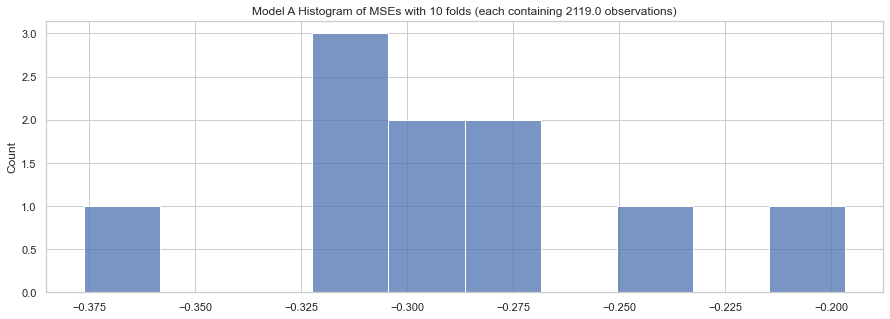

In [783]:
#visualize the cv_result
folds = 10
plt.figure(figsize = (15, 5))
sns.histplot(cv_result, bins = 10);
plt.title('Model A Histogram of MSEs with {} folds (each containing {} observations)'
          .format(folds, round(len(preprocessed_B) / folds, 0)));
plt.savefig('./Data & Figures/model_B_cv_result_histplot')

Without log-transformation of data, we keep failing the normality and homoscedasticity assumptions. 

## Validate Model B

In [784]:
#split the data into training and test sets. Use the default split size
X_train, X_test, y_train, y_test = train_test_split(X[selected_features], y, test_size = 0.2, random_state = 42)
print(len(X_train), len(y_train), len(X_test), len(y_test))

linreg = LinearRegression()

#fit the model to train data
linreg.fit(X_train, y_train)

#calculate predictions on training and test sets
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

#calculate residuals (prediction - actual error)
train_residual = y_hat_train - y_train
test_residual = y_hat_test - y_test

#calculate training and test RMSE
train_rmse = mean_squared_error(y_train, y_hat_train, squared = False)
test_rmse = mean_squared_error(y_test, y_hat_test, squared = False)

print(train_rmse)
print(test_rmse)

16950 16950 4238 4238
0.5357511479265694
0.5360749751223352


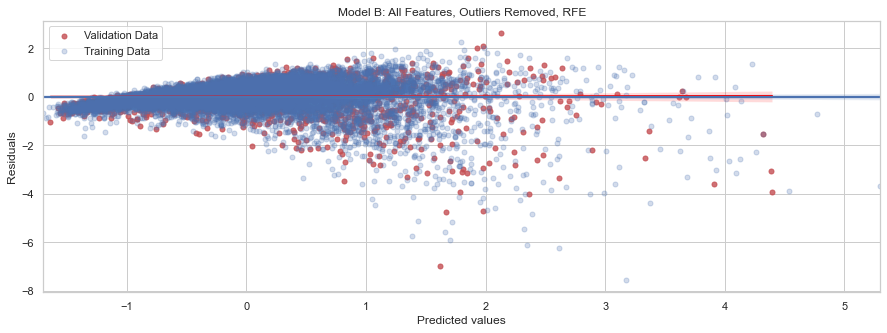

<Figure size 432x288 with 0 Axes>

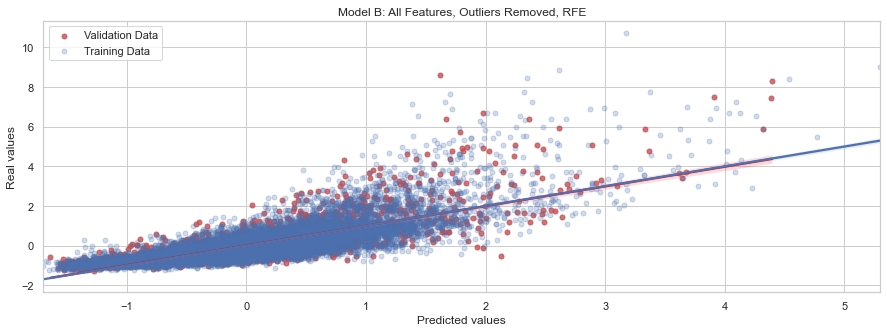

<Figure size 432x288 with 0 Axes>

In [785]:
#plot residuals: 
plt.figure(figsize = (15, 5))
sns.regplot(x = y_hat_test, y = y_hat_test - y_test,
            scatter_kws = {'s': 25}, 
            line_kws = {'color': 'red'},
            color = 'r',
            fit_reg = True, label = 'Validation Data')
sns.regplot(x = y_hat_train, y = y_hat_train - y_train,
            scatter_kws = {'s': 25,'alpha': 0.25}, 
            fit_reg = True, label = 'Training Data')


plt.title('Model B: All Features, Outliers Removed, RFE')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc = 'upper left')
plt.show()
plt.savefig('./Data & Figures/model_B_residuals_regplot')

#plot predictions
plt.figure(figsize = (15, 5))
sns.regplot(x = y_hat_test, y = y_test,
            scatter_kws = {'s': 25}, 
            line_kws = {'color': 'red'}, 
            color = 'r',
            fit_reg = True, label = 'Validation Data')
sns.regplot(x = y_hat_train, y = y_train,
            scatter_kws = {'s': 25,'alpha':0.25}, 
            fit_reg = True, label = 'Training Data')

plt.title('Model B: All Features, Outliers Removed, RFE')
plt.xlabel('Predicted values')
plt.ylabel('Real values')
plt.legend(loc = 'upper left')
plt.show()
plt.savefig('./Data & Figures/model_B_predictions_regplot')

In [786]:
#get accuracy percentage
accuracy = linreg.score(X_test, y_test)
'Accuracy: {}%'.format(int(round(accuracy * 100)))

'Accuracy: 64%'

In [787]:
#get bias/variance tradeoff

#transform with MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

#scale the train set
X_train_scaled = scaler.fit_transform(X_train)

#scale the test set
X_test_scaled = scaler.transform(X_test)

#training set predictions
lm_train_predictions = linreg.predict(X_train_scaled)

# Test set predictions 
lm_test_predictions = linreg.predict(X_test_scaled)

#bias and variance for training set 
b_train = bias(y_train, lm_train_predictions) 
v_train = variance(lm_train_predictions) 
print('Train bias: {} \nTrain variance: {}'.format(b_train, v_train))

#bias and variance for test set 
b_test = bias(y_test, lm_test_predictions) 
v_test = variance(lm_test_predictions) 
print('Test bias: {} \nTest variance: {}'.format(b_test, v_test))

Train bias: 0.16968353025916813 
Train variance: 0.20843375904757572
Test bias: 0.16323940425182504 
Test variance: 0.20986246274746143


In [788]:
#save model
tuple_objects = (linreg, X_train, y_train)
pickle.dump(tuple_objects, open('./Data & Figures/model_B.pkl','wb'))

In [789]:
summary_table_1.loc[1] = ['Model B', 'All features, outliers removed, RFE', len(selected_features), 
                          r2_score(y, yhat), accuracy * 100, 
                          train_rmse, test_rmse,
                          b_train, b_test, v_train, v_test,
                          cv_result.mean(),
                          'P', 'F', 'F']
summary_table_1.head()

,Model,Description,Num Features,r2,Accuracy,RMSE Train,RMSE Test,Bias Train,Bias Test,Variance Train,Variance Test,Cross Validation,Multicollinearity,Normality,Homoscedasticity
0,Model A,All features,19.0,0.668177,66.236718,0.562527,0.628671,0.186644,0.179878,0.210681,0.205261,-0.336890,P,F,F
1,Model B,"All features, outliers removed, RFE",10.0,0.642821,63.983660,0.535751,0.536075,0.169684,0.163239,0.208434,0.209862,-0.289727,P,F,F


# MODEL C
## POLYNOMIAL REGRESSION

Without log-transformation of data, we keep failing the normality and homoscedasticity assumptions. The troublesome features are 'price', 'sqft_above', 'sqft_lot', 'sqft_living15', and 'sqft_lot15'.

Model C will be a refinement of Model A, since Model B (with outliers removed) did not improve and we don't want to remove outliers without a convincing reason.

In [790]:
#create new dataframe
preprocessed_C = preprocessed_A.copy(deep = True)

preprocessed_C.head(2)

,price,sqft_above,sqft_lot,sqft_living15,sqft_lot15,age,bedrooms,bathrooms,floors,water_1.0,...,cond_5.0,zip_A,zip_B,zip_C,zip_D,zip_E,zip_F,zip_G,zip_H,zip_I
15937,-0.740571,-1.099527,-0.169225,-1.441766,-0.170986,0.955962,3,1.00,1.0,0,...,0,0,0,0,0,1,0,0,0,0
20963,-0.384457,-1.075393,-0.340062,-0.799934,-0.423750,-1.357975,2,1.75,1.5,0,...,0,0,0,0,0,0,0,1,0,0


In [791]:
#transform non-normal features
preprocessed_C['sqft_above_poly'] = preprocessed_C['sqft_above']**2
preprocessed_C['sqft_lot_poly'] = preprocessed_C['sqft_lot']**2
preprocessed_C['sqft_living15_poly'] = preprocessed_C['sqft_living15']**2
preprocessed_C['sqft_lot15_poly'] = preprocessed_C['sqft_lot15']**2

In [792]:
#drop old values
preprocessed_C.drop(['sqft_above', 'sqft_lot', 'sqft_living15', 'sqft_lot15'], axis = 1, inplace = True)

In [793]:
#review dataframe
preprocessed_C.head(2)

,price,age,bedrooms,bathrooms,floors,water_1.0,base_1.0,reno_1.0,cond_2.0,cond_3.0,...,zip_D,zip_E,zip_F,zip_G,zip_H,zip_I,sqft_above_poly,sqft_lot_poly,sqft_living15_poly,sqft_lot15_poly
15937,-0.740571,0.955962,3,1.00,1.0,0,1,0,0,1,...,0,1,0,0,0,0,1.208959,0.028637,2.078689,0.029236
20963,-0.384457,-1.357975,2,1.75,1.5,0,1,0,0,1,...,0,0,0,1,0,0,1.156469,0.115642,0.639894,0.179564


In [794]:
#redefine X_train and y_train
X = preprocessed_C.drop(['price'], axis = 1)
y = preprocessed_C['price']

In [795]:
#drop p > 0.05
preprocessed_C.drop('bathrooms', axis = 1, inplace = True)

In [796]:
#apply stepwise function to make sure we only select impactful features
result_C = stepwise_selection(X, y, verbose = True)
print('Resulting Features:')
print(result_C)

Add  zip_C                          with p-value 0.0
Add  bedrooms                       with p-value 0.0
Add  bathrooms                      with p-value 0.0
Add  zip_A                          with p-value 0.0
Add  sqft_above_poly                with p-value 0.0
Add  water_1.0                      with p-value 0.0
Add  zip_B                          with p-value 3.87051e-253
Add  sqft_living15_poly             with p-value 1.95844e-219
Add  age                            with p-value 4.27059e-201
Add  zip_G                          with p-value 1.69925e-189
Add  zip_I                          with p-value 6.89267e-26
Add  floors                         with p-value 1.52982e-22
Add  base_1.0                       with p-value 2.6251e-47
Add  reno_1.0                       with p-value 9.83632e-13
Add  cond_3.0                       with p-value 1.74446e-14
Add  sqft_lot_poly                  with p-value 1.98258e-09
Add  zip_F                          with p-value 7.40207e-09
Add  con

## Build Model C

In [797]:
#interecept is not included by default and should be added manually
X_in = X[result_C]
X_intercept = sm.add_constant(X_in) 

#estimation by ordinary least squares (OLS)
model_C = sm.OLS(y, X_intercept).fit() 

#get summary
model_C.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.585
Method:                 Least Squares   F-statistic:                     1575.
Date:                Wed, 03 Feb 2021   Prob (F-statistic):               0.00
Time:                        00:10:41   Log-Likelihood:                -18415.
No. Observations:               21188   AIC:                         3.687e+04
Df Residuals:                   21168   BIC:                         3.703e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -1.9673      0.022    -87.459      0.000      -2.011      -1.923
zip_C                  0.8121      0.016     50.030      0.000       0.780       0.844
bedrooms               0.0498      0.006      8.984      0.000       0.039       0.061
bathrooms              0.4555      0.009     51.713      0.000       0.438       0.473
zip_A                  0.5116      0.014     36.406      0.000       0.484       0.539
sqft_above_poly        0.1072      0.003     37.125      0.000       0.102       0.113
water_1.0              2.2162      0.051     43.510      0.000       2.116       2.316
zip_B                  0.5510      0.015     35.582      0.000       0.521       0.581
sqft_living15_poly     0.0867      0.003     30.964      0.000       0.081       0.092
age                    0.1649      0.006     26.762      0.000       0.153       0.177
zip_G                  0.4439      0.018     24.987      0.000       0.409       0.479
zip_I                  0.2249      0.026      8.556      0.000       0.173       0.276
floors                 0.1568      0.010     15.026      0.000       0.136       0.177
base_1.0               0.1416      0.010     14.445      0.000       0.122       0.161
reno_1.0               0.1915      0.023      8.259      0.000       0.146       0.237
cond_3.0              -0.0789      0.010     -8.276      0.000      -0.098      -0.060
sqft_lot_poly          0.0014      0.000      5.940      0.000       0.001       0.002
zip_F                 -0.1171      0.018     -6.542      0.000      -0.152      -0.082
cond_2.0              -0.2415      0.046     -5.250      0.000      -0.332      -0.151
zip_D                 -0.0564      0.018     -3.123      0.002      -0.092      -0.021
==============================================================================
Omnibus:                    11098.339   Durbin-Watson:                   1.178
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           183348.891
Skew:                           2.139   Prob(JB):                         0.00
Kurtosis:                      16.762   Cond. No.                         216.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [798]:
#create linear regression object
linreg = LinearRegression()

#fit model
linreg.fit(X[result_C], y)

#predict yhat using our model
yhat = linreg.predict(X[result_C])
yhat

array([-0.67545315, -0.37318999, -0.16766649, ..., -1.14706158,
       -0.40839693, -0.23751394])

In [799]:
#get intercept
linreg.intercept_

-1.9672598388643212

In [800]:
#get coefficients and sort them
coefficients_C = dict(zip(X[result_C], list(linreg.coef_)))
dict(sorted(coefficients_C.items(), key = lambda item: item[1]))

{'cond_2.0': -0.24154577391296772,
 'zip_F': -0.11705915513807558,
 'cond_3.0': -0.07893765952619301,
 'zip_D': -0.05644180235046152,
 'sqft_lot_poly': 0.0014146441013515249,
 'bedrooms': 0.049759368628299355,
 'sqft_living15_poly': 0.08668056944443064,
 'sqft_above_poly': 0.10720668933078535,
 'base_1.0': 0.14164430817961995,
 'floors': 0.15684939412110588,
 'age': 0.1649444798629858,
 'reno_1.0': 0.19146628359576076,
 'zip_I': 0.22493263902004795,
 'zip_G': 0.4438932738612177,
 'bathrooms': 0.45546081293424384,
 'zip_A': 0.5116350919385844,
 'zip_B': 0.5510461106519593,
 'zip_C': 0.8120786344026752,
 'water_1.0': 2.216176518706705}

In [801]:
lists_C = sorted(coefficients_C.items(), key = lambda item: item[1])
a, b = zip(*lists_C)
fig = go.Figure(go.Waterfall(x  = a, y = b, 
                             name = "coefficients"))
fig.update_layout(title = 'Model C Coefficients',
                  showlegend = True)
fig.update_xaxes(title_text = 'Features', tickangle = 90)
fig.update_yaxes(title_text = 'Coefficients')
fig.show()
#fig.write_image('./Data & Figures/model_C_waterfall.png')

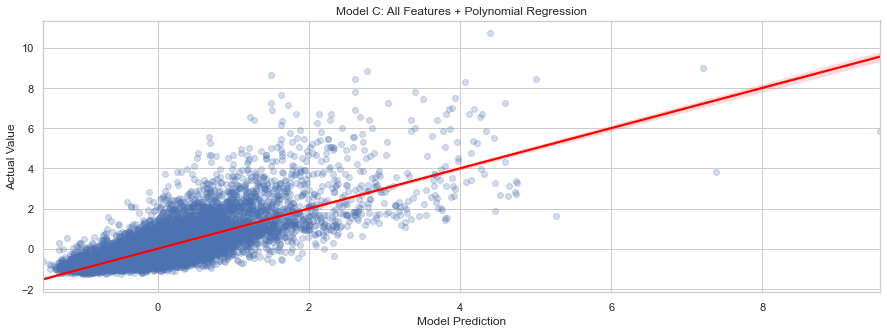

In [802]:
#plot y_hat
plt.figure(figsize = (15, 5))
sns.regplot(yhat, y, 
            line_kws = {'color': 'red'},
            scatter_kws = {'color':'b','alpha':0.25},color='r')
plt.title('Model C: All Features + Polynomial Regression')
plt.xlabel('Model Prediction')
plt.ylabel('Actual Value');
plt.savefig('./Data & Figures/model_C_regplot')

## Rank Features for Model C

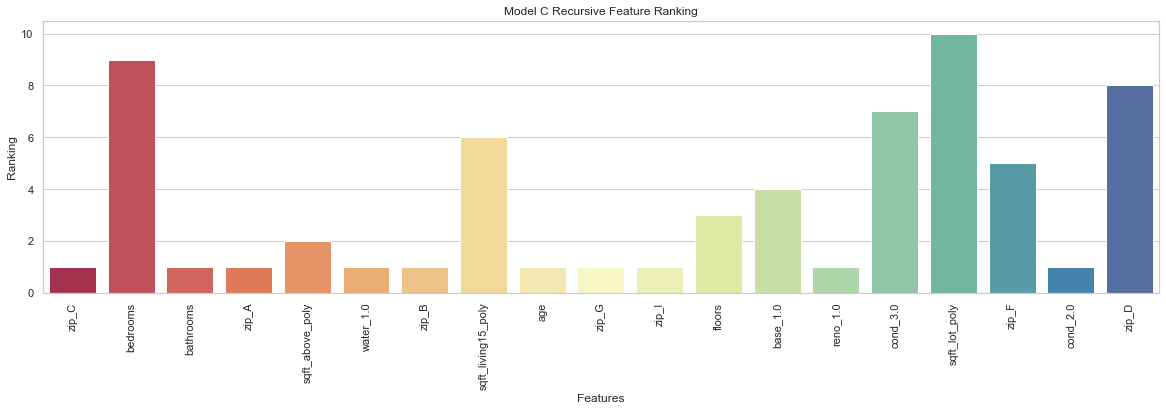

<Figure size 432x288 with 0 Axes>

In [803]:
linreg = LinearRegression()

#set number of features to be 10
selector = RFE(linreg, n_features_to_select = 10) 

#convert y to 1d np array to prevent DataConversionWarning
selector = selector.fit(X[result_C], y.values.ravel()) 
selector.support_

#plot features ranking
plt.figure(figsize = (20, 5))
sns.barplot(x = X[result_C].columns, y = selector.ranking_, palette = 'Spectral');
plt.title('Model C Recursive Feature Ranking')
plt.xlabel('Features')
plt.ylabel('Ranking')
plt.xticks(rotation = 90)
plt.show()
plt.savefig('./Data & Figures/model_C_recursive_features_elimination')


## Test Model C

In [804]:
#recheck for multicollinearity
vif = [variance_inflation_factor(X[result_C].values, i) for i in range(X[result_C].shape[1])] 
list(zip(result_C, vif))

[('zip_C', 1.8630982251486408),
 ('bedrooms', 18.070345813439065),
 ('bathrooms', 23.764850068690603),
 ('zip_A', 4.03253924604794),
 ('sqft_above_poly', 2.0396871332547724),
 ('water_1.0', 1.0268412547001378),
 ('zip_B', 1.8788718818306456),
 ('sqft_living15_poly', 2.0347860297968934),
 ('age', 2.0798903827733612),
 ('zip_G', 1.6384748006728393),
 ('zip_I', 1.1966181268809553),
 ('floors', 15.228921717421958),
 ('base_1.0', 2.3794953728311947),
 ('reno_1.0', 1.1469983140163114),
 ('cond_3.0', 3.4906868851864035),
 ('sqft_lot_poly', 1.013862427388213),
 ('zip_F', 1.465837109594333),
 ('cond_2.0', 1.0202414039182994),
 ('zip_D', 1.4637555345293336)]

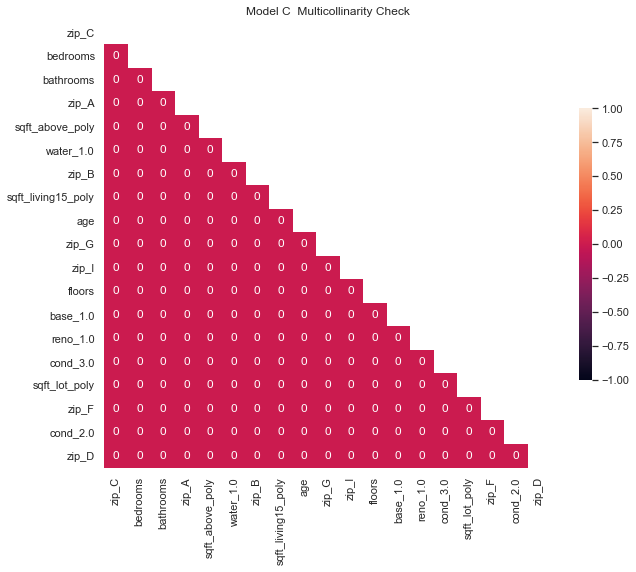

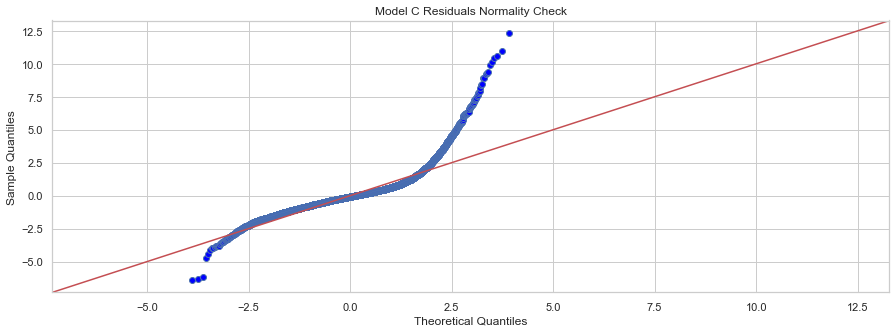

<Figure size 432x288 with 0 Axes>

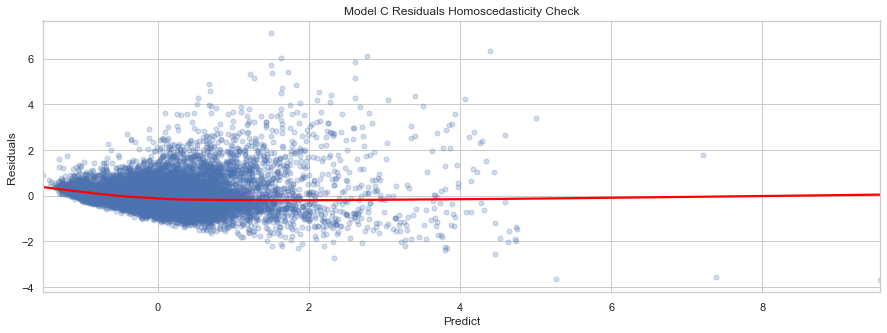

<Figure size 432x288 with 0 Axes>

In [805]:
#recheck for multicollinearity
mask = np.zeros_like(abs(X[result_C].corr()) > 0.75)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize = (10, 10))
    ax = sns.heatmap(abs(X[result_C].corr()) > 0.75, 
                     annot = True, 
                     ax = ax, 
                     cbar_kws = {"shrink": .5}, 
                     mask = mask, 
                     vmax = 1,
                     vmin = -1,
                     square = True)
    plt.title('Model C  Multicollinarity Check')
plt.savefig('./Data & Figures/model_C_multicollinarity_check')

#recheck for normality
fig = sm.graphics.qqplot(model_C.resid, 
                         dist = stats.norm, 
                         line = '45', 
                         fit = True)
fig.set_size_inches(15, 5)
plt.title('Model C Residuals Normality Check')
plt.show()
plt.savefig('./Data & Figures/model_C_residuals_qqplot')

#recheck for homoscedasticity
plt.figure(figsize = (15, 5))
sns.regplot(x = model_C.predict(), 
            y = model_C.resid, 
            lowess = True, 
            line_kws = {'color': 'red'},
            scatter_kws = {'s': 25,'alpha':0.25})
plt.title('Model C Residuals Homoscedasticity Check')
plt.xlabel('Predict')
plt.ylabel('Residuals')
plt.show()
plt.savefig('./Data & Figures/model_C_homoscedasticity_regplot')

In [806]:
#Goldfeld-Quandt test
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(model_C.resid, model_C.model.exog)
list(zip(name, test))

[('F statistic', 1.1471305582518225), ('p-value', 8.662744383450057e-13)]

In [807]:
#cross-validation to check for overfitting
linreg = LinearRegression()

cv_result = cross_val_score(linreg, X[result_C], y, cv = 10, scoring = 'neg_mean_squared_error')
print(cv_result.mean())

-0.33774218438581566


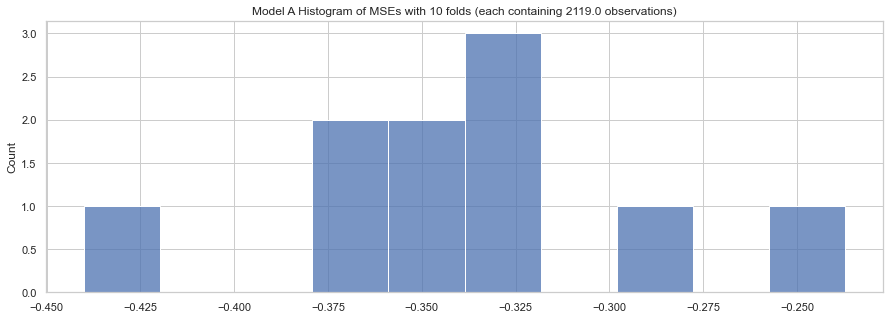

In [808]:
#visualize the cv_result
folds = 10
plt.figure(figsize = (15, 5))
sns.histplot(cv_result, bins = 10);
plt.title('Model A Histogram of MSEs with {} folds (each containing {} observations)'
          .format(folds, round(len(preprocessed_C) / folds, 0)));
plt.savefig('./Data & Figures/model_C_cv_result_histplot')

## Validate Model C

In [809]:
#split the data into training and test sets. Use the default split size
X_train, X_test, y_train, y_test = train_test_split(X[result_C], y, test_size = 0.2, random_state = 42)
print(len(X_train), len(y_train), len(X_test), len(y_test))

linreg = LinearRegression()

#fit the model to train data
linreg.fit(X_train, y_train)

#calculate predictions on training and test sets
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

#calculate residuals (prediction - actual error)
train_residual = y_hat_train - y_train
test_residual = y_hat_test - y_test

train_rmse = mean_squared_error(y_train, y_hat_train, squared = False)
test_rmse = mean_squared_error(y_test, y_hat_test, squared = False)

print(train_rmse)
print(test_rmse)

16950 16950 4238 4238
0.5749447176169188
0.5859855961130669


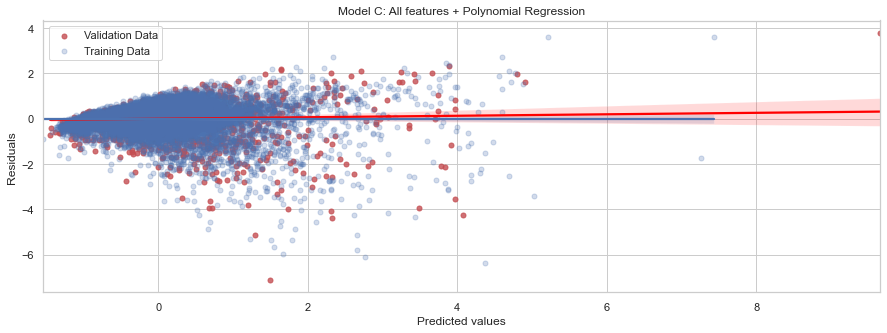

<Figure size 432x288 with 0 Axes>

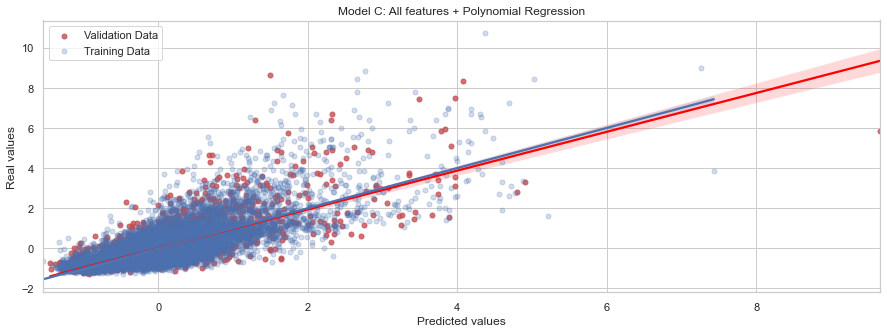

<Figure size 432x288 with 0 Axes>

In [810]:
#plot residuals: 
plt.figure(figsize = (15, 5))
sns.regplot(x = y_hat_test, y = y_hat_test - y_test,
            scatter_kws = {'s': 25}, 
            line_kws = {'color': 'red'},
            color = 'r',
            fit_reg = True, label = 'Validation Data')
sns.regplot(x = y_hat_train, y = y_hat_train - y_train,
            scatter_kws = {'s': 25,'alpha': 0.25}, 
            fit_reg = True, label = 'Training Data')


plt.title('Model C: All features + Polynomial Regression')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc = 'upper left')
plt.show()
plt.savefig('./Data & Figures/model_C_residuals_regplot')

#plot predictions
plt.figure(figsize = (15, 5))
sns.regplot(x = y_hat_test, y = y_test,
            scatter_kws = {'s': 25}, 
            line_kws = {'color': 'red'}, 
            color = 'r',
            fit_reg = True, label = 'Validation Data')
sns.regplot(x = y_hat_train, y = y_train,
            scatter_kws = {'s': 25,'alpha':0.25}, 
            fit_reg = True, label = 'Training Data')

plt.title('Model C: All features + Polynomial Regression')
plt.xlabel('Predicted values')
plt.ylabel('Real values')
plt.legend(loc = 'upper left')
plt.show()
plt.savefig('./Data & Figures/model_C_predictions_regplot')

In [811]:
#get accuracy percentage
accuracy = linreg.score(X_test, y_test)
"Accuracy: {}%".format(int(round(accuracy * 100)))

'Accuracy: 57%'

In [812]:
#get bias/variance tradeoff

#transform with MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

#scale the train set
X_train_scaled = scaler.fit_transform(X_train)

#scale the test set
X_test_scaled = scaler.transform(X_test)

#training set predictions
lm_train_predictions = linreg.predict(X_train_scaled)

# Test set predictions 
lm_test_predictions = linreg.predict(X_test_scaled)

#bias and variance for training set 
b_train = bias(y_train, lm_train_predictions) 
v_train = variance(lm_train_predictions) 
print('Train bias: {} \nTrain variance: {}'.format(b_train, v_train))

#bias and variance for test set 
b_test = bias(y_test, lm_test_predictions) 
v_test = variance(lm_test_predictions) 
print('Test bias: {} \nTest variance: {}'.format(b_test, v_test))

Train bias: -1.2273176280532754 
Train variance: 0.1543616039235749
Test bias: -1.2276591556863228 
Test variance: 0.15529662614985185


In [813]:
#save model
tuple_objects = (linreg, X_train, y_train)
pickle.dump(tuple_objects, open('./Data & Figures/model_C.pkl','wb'))

In [814]:
summary_table_1.loc[2] = ['Model C', 'All features + Polynomial Regression', len(result_C), 
                          r2_score(y, yhat), accuracy * 100, 
                          train_rmse, test_rmse,
                          b_train, b_test, v_train, v_test,
                          cv_result.mean(),
                          'P', 'F', 'F']
summary_table_1.head()

,Model,Description,Num Features,r2,Accuracy,RMSE Train,RMSE Test,Bias Train,Bias Test,Variance Train,Variance Test,Cross Validation,Multicollinearity,Normality,Homoscedasticity
0,Model A,All features,19.0,0.668177,66.236718,0.562527,0.628671,0.186644,0.179878,0.210681,0.205261,-0.336890,P,F,F
1,Model B,"All features, outliers removed, RFE",10.0,0.642821,63.983660,0.535751,0.536075,0.169684,0.163239,0.208434,0.209862,-0.289727,P,F,F
2,Model C,All features + Polynomial Regression,19.0,0.585625,56.964942,0.574945,0.585986,-1.227318,-1.227659,0.154362,0.155297,-0.337742,P,F,F


# MODEL D
## log(X)

In [815]:
preprocessed_log_D = clean[['price', 'sqft_above_log', 'sqft_lot_log', 'sqft_living15_log',
                            'age', 'bedrooms', 'bathrooms', 'floors',
                            'water_1.0', 'base_1.0', 'reno_1.0',
                            'cond_2.0', 'cond_3.0', 'cond_5.0',
                            'zip_A', 'zip_B', 'zip_C', 'zip_E', 'zip_D', 'zip_F', 'zip_G', 'zip_H', 'zip_I']]
preprocessed_log_D.head()

,price,sqft_above_log,sqft_lot_log,sqft_living15_log,age,bedrooms,bathrooms,floors,water_1.0,base_1.0,...,cond_5.0,zip_A,zip_B,zip_C,zip_E,zip_D,zip_F,zip_G,zip_H,zip_I
15937,-0.740571,-1.443346,0.011001,-1.932101,0.955962,3,1.00,1.0,0,1,...,0,0,0,0,1,0,0,0,0,0
20963,-0.384457,-1.390746,-2.297864,-0.818484,-1.357975,2,1.75,1.5,0,1,...,0,0,0,0,0,0,0,1,0,0
7614,-0.550073,-1.913036,-0.734773,-0.673521,0.989991,3,1.00,1.0,0,1,...,0,1,0,0,0,0,0,0,0,0
3257,-0.438575,-1.552231,-0.093192,0.075960,1.092076,2,1.00,1.0,0,1,...,1,1,0,0,0,0,0,0,0,0
16723,-0.479367,-0.044048,-0.724104,-1.400849,1.500418,5,2.00,1.5,0,0,...,0,1,0,0,0,0,0,0,0,0


In [816]:
#drop p-value > 0.05
preprocessed_log_D.drop('water_1.0', axis = 1, inplace = True)

In [817]:
#drop p-value > 0.05
#preprocessed_log_D.drop('zip_C', axis = 1)

In [818]:
X = preprocessed_log_D.drop(['price'], axis=1)
y = preprocessed_log_D['price']

In [819]:
#apply stepwise function
result_D = stepwise_selection(X, y, verbose = True)
print('Resulting Features:')
print(result_D)

Add  zip_C                          with p-value 0.0
Add  bedrooms                       with p-value 0.0
Add  bathrooms                      with p-value 0.0
Add  zip_A                          with p-value 0.0
Add  sqft_lot_log                   with p-value 0.0
Add  sqft_living15_log              with p-value 0.0
Add  sqft_above_log                 with p-value 2.78811e-213
Add  age                            with p-value 3.39341e-268
Add  zip_B                          with p-value 4.51967e-150
Add  base_1.0                       with p-value 2.83909e-123
Add  zip_G                          with p-value 5.74691e-84
Add  zip_E                          with p-value 1.10138e-34
Add  zip_I                          with p-value 5.82555e-13
Add  reno_1.0                       with p-value 7.06029e-11
Add  cond_3.0                       with p-value 5.93223e-11
Add  cond_5.0                       with p-value 5.36837e-06
Add  zip_D                          with p-value 9.96414e-06
Resulti

## Build Model D

In [820]:
#build model in statsmodels
#interecept is not included by default and should be added manually
X_in = X[result_D]
X_intercept = sm.add_constant(X_in) 

#estimation by ordinary least squares (OLS)
model_D = sm.OLS(y, X_intercept).fit() 

#get summary
model_D.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.579
Model:                            OLS   Adj. R-squared:                  0.578
Method:                 Least Squares   F-statistic:                     1729.
Date:                Wed, 03 Feb 2021   Prob (F-statistic):               0.00
Time:                        00:11:09   Log-Likelihood:                -21135.
No. Observations:               21420   AIC:                         4.231e+04
Df Residuals:                   21402   BIC:                         4.245e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.8795      0.029    -30.320      0.000      -0.936      -0.823
zip_C                 0.9242      0.018     51.915      0.000       0.889       0.959
bedrooms             -0.1341      0.006    -21.026      0.000      -0.147      -0.122
bathrooms             0.3290      0.010     32.311      0.000       0.309       0.349
zip_A                 0.8433      0.017     50.660      0.000       0.811       0.876
sqft_lot_log          0.0477      0.006      8.519      0.000       0.037       0.059
sqft_living15_log     0.1918      0.007     27.030      0.000       0.178       0.206
sqft_above_log        0.4252      0.009     45.836      0.000       0.407       0.443
age                   0.1737      0.007     25.332      0.000       0.160       0.187
zip_B                 0.5607      0.017     33.068      0.000       0.528       0.594
base_1.0              0.2730      0.012     23.225      0.000       0.250       0.296
zip_G                 0.4499      0.019     23.102      0.000       0.412       0.488
zip_E                 0.3103      0.022     14.384      0.000       0.268       0.353
zip_I                 0.2427      0.029      8.342      0.000       0.186       0.300
reno_1.0              0.2021      0.026      7.858      0.000       0.152       0.252
cond_3.0             -0.0549      0.011     -4.874      0.000      -0.077      -0.033
cond_5.0              0.0838      0.018      4.595      0.000       0.048       0.120
zip_D                 0.0887      0.020      4.419      0.000       0.049       0.128
==============================================================================
Omnibus:                    21933.804   Durbin-Watson:                   1.354
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3300197.266
Skew:                           4.769   Prob(JB):                         0.00
Kurtosis:                      63.056   Cond. No.                         37.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [821]:
#create linear regression object
linreg = LinearRegression()

#fit model
linreg.fit(X[result_D], y)

#predict yhat using our model
yhat = linreg.predict(X[result_D])
yhat

array([-1.24224967, -0.99790314, -0.64235655, ..., -0.50138075,
       -0.20433328, -0.42410443])

In [822]:
#get intercept
linreg.intercept_

-0.8794524716481602

In [823]:
#get coefficients and sort them
coefficients_D = dict(zip(X[result_D], list(linreg.coef_)))
dict(sorted(coefficients_D.items(), key = lambda item: item[1]))

{'bedrooms': -0.13414772689431503,
 'cond_3.0': -0.054856911538447954,
 'sqft_lot_log': 0.04772111207146321,
 'cond_5.0': 0.08377365068930473,
 'zip_D': 0.08865540982891731,
 'age': 0.17372497255336428,
 'sqft_living15_log': 0.19183039843335697,
 'reno_1.0': 0.20205749126267378,
 'zip_I': 0.2426845509664939,
 'base_1.0': 0.2729964142883518,
 'zip_E': 0.3102582242724306,
 'bathrooms': 0.32899420823327596,
 'sqft_above_log': 0.425199299506226,
 'zip_G': 0.44989048735989307,
 'zip_B': 0.5607395145894807,
 'zip_A': 0.8432500099785106,
 'zip_C': 0.9242318671639806}

In [824]:
lists_D = sorted(coefficients_D.items(), key = lambda item: item[1])
a, b = zip(*lists_D)
fig = go.Figure(go.Waterfall(x  = a, y = b, 
                             name = "coefficients"))
fig.update_layout(title = 'Model D Coefficients',
                  showlegend = True)
fig.update_xaxes(title_text = 'Features', tickangle = 90)
fig.update_yaxes(title_text = 'Coefficients')
fig.show()
#fig.write_image('./Data & Figures/model_D_waterfall.png')

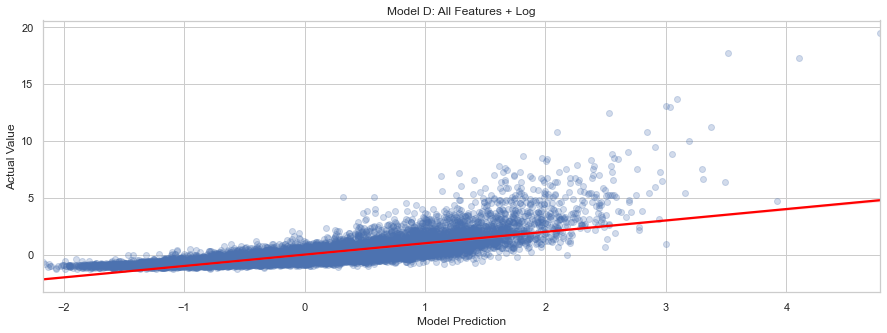

In [825]:
#plot y_hat
plt.figure(figsize = (15, 5))
sns.regplot(yhat, y, 
            line_kws = {'color': 'red'},
            scatter_kws = {'color':'b','alpha': 0.25},color='r')
plt.title('Model D: All Features + Log')
plt.xlabel('Model Prediction')
plt.ylabel('Actual Value');
plt.savefig('./Data & Figures/model_D_scatterplot')

## Rank Features for Model D

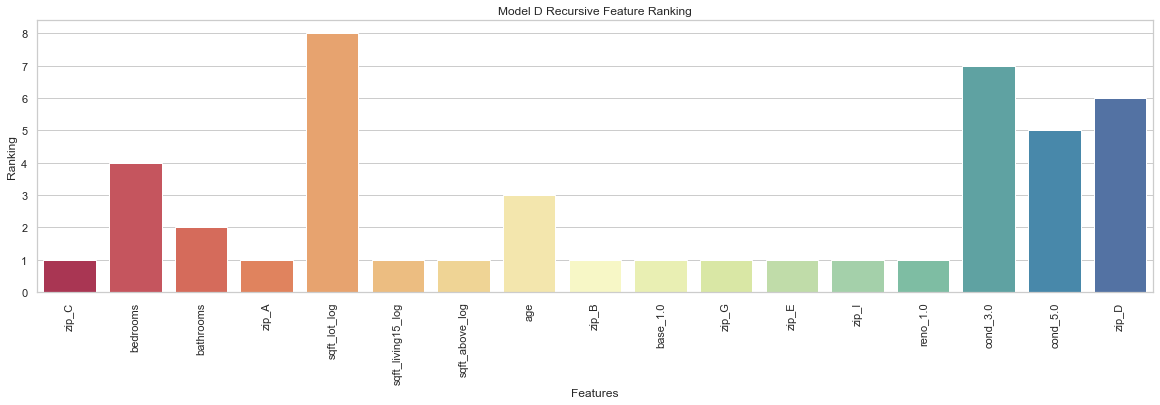

<Figure size 432x288 with 0 Axes>

In [826]:
linreg = LinearRegression()

#set number of features to be 10
selector = RFE(linreg, n_features_to_select = 10) 

#convert y to 1d np array to prevent DataConversionWarning
selector = selector.fit(X[result_D], y.values.ravel()) 
selector.support_

#plot features ranking
plt.figure(figsize = (20, 5))
sns.barplot(x = X[result_D].columns, y = selector.ranking_, palette = 'Spectral');
plt.title('Model D Recursive Feature Ranking')
plt.xlabel('Features')
plt.ylabel('Ranking')
plt.xticks(rotation = 90)
plt.show()
plt.savefig('./Data & Figures/model_D_recursive_features_elimination')

**Best Predictive Features:**

* 'water_1.0'
* 'sqft_living15_log'
* 'zip_A'
* 'zip_C'
* 'sqft_above_log'
* 'zip_B'
* 'zip_G'
* 'base_1.0'
* 'zip_E'
* 'zip_I'

## Test Model D

In [827]:
#recheck for multicollinearity
vif = [variance_inflation_factor(X[result_D].values, i) for i in range(X[result_D].shape[1])] 
list(zip(result_D, vif))

[('zip_C', 1.819134131228552),
 ('bedrooms', 16.34225281444456),
 ('bathrooms', 19.698570717239082),
 ('zip_A', 4.396251793293161),
 ('sqft_lot_log', 1.5442411569233927),
 ('sqft_living15_log', 2.551534186300603),
 ('sqft_above_log', 3.185316495242326),
 ('age', 2.3597724590015265),
 ('zip_B', 1.8114743305353098),
 ('base_1.0', 2.456367636794294),
 ('zip_G', 1.5558417564305291),
 ('zip_E', 1.4428177808884128),
 ('zip_I', 1.1779013724987797),
 ('reno_1.0', 1.157379217196329),
 ('cond_3.0', 3.9001118472881697),
 ('cond_5.0', 1.3256693494750562),
 ('zip_D', 1.471600551158877)]

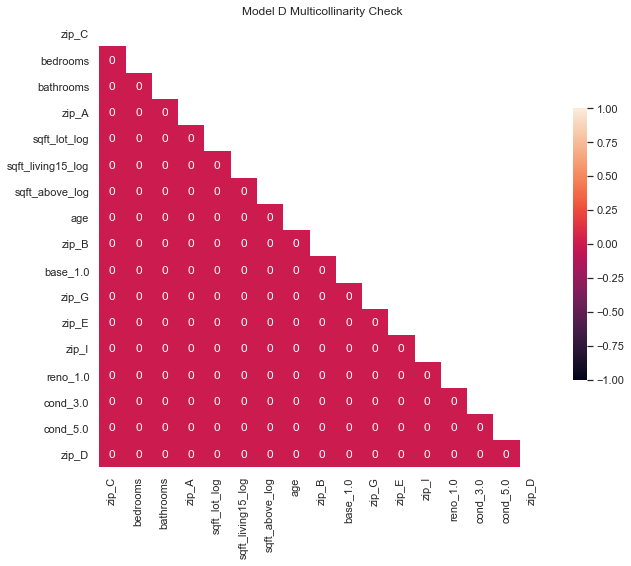

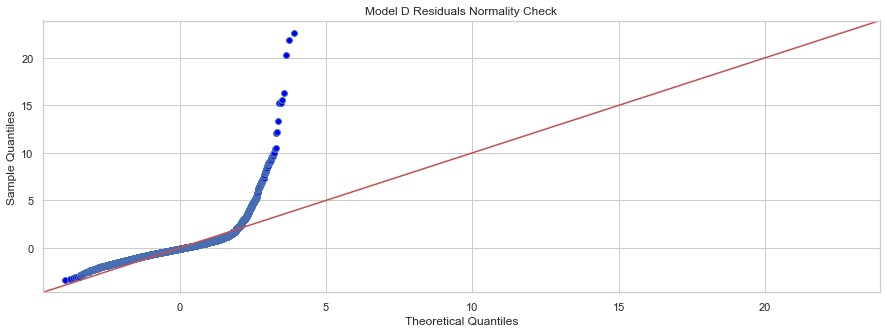

<Figure size 432x288 with 0 Axes>

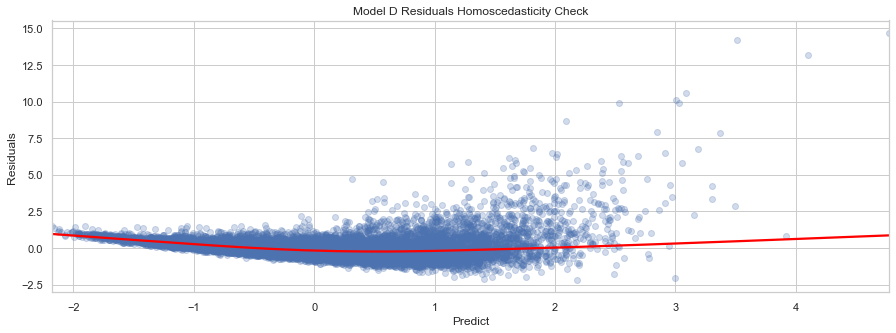

<Figure size 432x288 with 0 Axes>

In [828]:
#recheck for multicollinearity
mask = np.zeros_like(abs(X[result_D].corr()) > 0.75)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style('white'):
    fig, ax = plt.subplots(figsize = (10, 10))
    ax = sns.heatmap(abs(X[result_D].corr()) > 0.75, 
                     annot = True, 
                     ax = ax, 
                     cbar_kws = {"shrink": .5}, 
                     mask = mask, 
                     vmax = 1,
                     vmin = -1,
                     square = True)
    plt.title('Model D Multicollinarity Check')
plt.savefig('./Data & Figures/model_D_multicollinarity_check')

#recheck for normality
fig = sm.graphics.qqplot(model_D.resid, 
                         dist = stats.norm, 
                         line = '45', 
                         fit = True)
fig.set_size_inches(15, 5)
plt.title('Model D Residuals Normality Check')
plt.show()
plt.savefig('./Data & Figures/model_D_residuals_qqplot')

#recheck for homoscedasticity
plt.figure(figsize = (15, 5))
sns.regplot(x = model_D.predict(), 
            y = model_D.resid, 
            lowess = True, 
            line_kws = {'color': 'red'},
            scatter_kws = {'color':'b','alpha': 0.25}, color = 'r')
plt.title('Model D Residuals Homoscedasticity Check')
plt.xlabel('Predict')
plt.ylabel('Residuals')
plt.show()
plt.savefig('./Data & Figures/model_D_homoscedasticity_regplot')

In [829]:
#Goldfeld-Quandt test
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(model_D.resid, model_D.model.exog)
list(zip(name, test))

[('F statistic', 1.0116899860246251), ('p-value', 0.2739654060985013)]

-0.42503656849786686


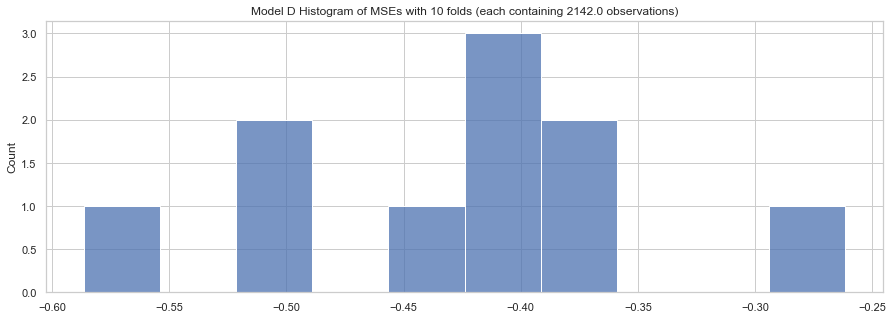

In [830]:
#cross-validation to check for overfitting
linreg = LinearRegression()

cv_result = cross_val_score(linreg, X[result_D], y, cv = 10, scoring = 'neg_mean_squared_error')
print(cv_result.mean())

#visualize the cv_result
folds = 10

plt.figure(figsize = (15, 5))
sns.histplot(cv_result, bins = 10);
plt.title('Model D Histogram of MSEs with {} folds (each containing {} observations)'
          .format(folds, round(len(preprocessed_log_D) / folds, 0)));
plt.savefig('./Data & Figures/model_D_cv_result_histplot')

## Validate Model D

In [831]:
#split the data into training and test sets. Use the default split size
X_train, X_test, y_train, y_test = train_test_split(X[result_D], y, test_size = 0.20, random_state = 42)
print(len(X_train), len(y_train), len(X_test), len(y_test))

linreg = LinearRegression()

#fit the model to train data
linreg.fit(X_train, y_train)

#calculate predictions on training and test sets
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

#calculate residuals
train_residual = y_hat_train - y_train
test_residual = y_hat_test - y_test

train_rmse = mean_squared_error(y_train, y_hat_train, squared = False)
test_rmse = mean_squared_error(y_test, y_hat_test, squared = False)

print(train_rmse)
print(test_rmse)

17136 17136 4284 4284
0.6308839853685854
0.7184528231831935


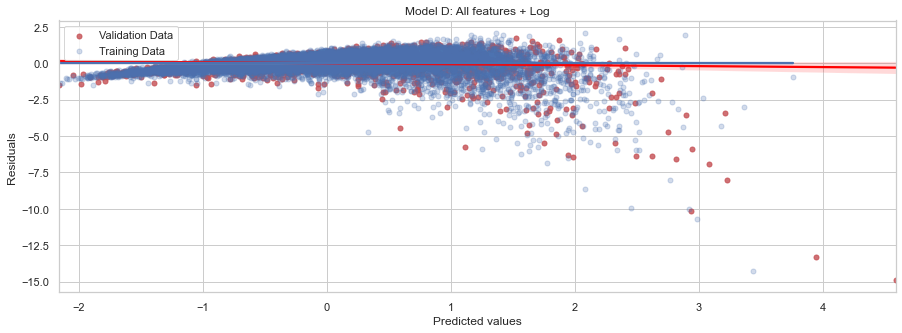

<Figure size 432x288 with 0 Axes>

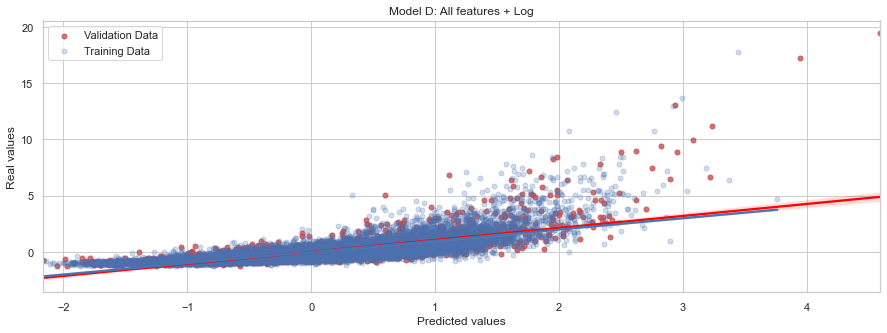

<Figure size 432x288 with 0 Axes>

In [832]:
#plot residuals: 
plt.figure(figsize = (15, 5))
sns.regplot(x = y_hat_test, y = y_hat_test - y_test,
            scatter_kws = {'s': 25}, 
            line_kws = {'color': 'red'},
            color = 'r',
            fit_reg = True, label = 'Validation Data')
sns.regplot(x = y_hat_train, y = y_hat_train - y_train,
            scatter_kws = {'s': 25,'alpha': 0.25}, 
            fit_reg = True, label = 'Training Data')


plt.title('Model D: All features + Log')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc = 'upper left')
plt.show()
plt.savefig('./Data & Figures/model_D_residuals_regplot')

#plot predictions
plt.figure(figsize = (15, 5))
sns.regplot(x = y_hat_test, y = y_test,
            scatter_kws = {'s': 25}, 
            line_kws = {'color': 'red'}, 
            color = 'r',
            fit_reg = True, label = 'Validation Data')
sns.regplot(x = y_hat_train, y = y_train,
            scatter_kws = {'s': 25,'alpha':0.25}, 
            fit_reg = True, label = 'Training Data')

plt.title('Model D: All features + Log')
plt.xlabel('Predicted values')
plt.ylabel('Real values')
plt.legend(loc = 'upper left')
plt.show()
plt.savefig('./Data & Figures/model_D_predictions_regplot')

In [833]:
#get accuracy percentage
accuracy = linreg.score(X_test, y_test)
"Accuracy: {}%".format(int(round(accuracy * 100)))

'Accuracy: 56%'

In [834]:
#get bias/variance tradeoff

#transform with MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

#scale the train set
X_train_scaled = scaler.fit_transform(X_train)

#scale the test set
X_test_scaled = scaler.transform(X_test)

#training set predictions
lm_train_predictions = linreg.predict(X_train_scaled)

# Test set predictions 
lm_test_predictions = linreg.predict(X_test_scaled)

#bias and variance for training set 
b_train = bias(y_train, lm_train_predictions) 
v_train = variance(lm_train_predictions) 
print('Train bias: {} \nTrain variance: {}'.format(b_train, v_train))

#bias and variance for test set 
b_test = bias(y_test, lm_test_predictions) 
v_test = variance(lm_test_predictions) 
print('Test bias: {} \nTest variance: {}'.format(b_test, v_test))

Train bias: 0.21713773822792953 
Train variance: 0.17234278299139683
Test bias: 0.21031438262289126 
Test variance: 0.16989302996144134


In [835]:
#save model
tuple_objects = (linreg, X_train, y_train)
pickle.dump(tuple_objects, open('./Data & Figures/model_D.pkl','wb'))

In [836]:
#update summary
summary_table_1.loc[3] = ['Model D', 'All features + Log(X)', len(result_D), 
                          r2_score(y, yhat), accuracy * 100, 
                          train_rmse, test_rmse,
                          b_train, b_test, v_train, v_test,
                          cv_result.mean(),
                          'P', 'F', 'F']
summary_table_1.head()

,Model,Description,Num Features,r2,Accuracy,RMSE Train,RMSE Test,Bias Train,Bias Test,Variance Train,Variance Test,Cross Validation,Multicollinearity,Normality,Homoscedasticity
0,Model A,All features,19.0,0.668177,66.236718,0.562527,0.628671,0.186644,0.179878,0.210681,0.205261,-0.336890,P,F,F
1,Model B,"All features, outliers removed, RFE",10.0,0.642821,63.983660,0.535751,0.536075,0.169684,0.163239,0.208434,0.209862,-0.289727,P,F,F
2,Model C,All features + Polynomial Regression,19.0,0.585625,56.964942,0.574945,0.585986,-1.227318,-1.227659,0.154362,0.155297,-0.337742,P,F,F
3,Model D,All features + Log(X),17.0,0.578698,55.904542,0.630884,0.718453,0.217138,0.210314,0.172343,0.169893,-0.425037,P,F,F


# MODEL E
## Log(y)

In [837]:
preprocessed_log_E = clean[['price_log', 
                            'sqft_above', 'sqft_lot', 'sqft_living15',
                            'age', 'bedrooms', 'bathrooms', 'floors',
                            'water_1.0', 'base_1.0', 'reno_1.0',
                            'cond_2.0', 'cond_3.0', 'cond_5.0',
                            'zip_A', 'zip_B', 'zip_C', 'zip_E', 'zip_D', 'zip_F', 'zip_G', 'zip_H', 'zip_I']]

preprocessed_log_E.head()

,price_log,sqft_above,sqft_lot,sqft_living15,age,bedrooms,bathrooms,floors,water_1.0,base_1.0,...,cond_5.0,zip_A,zip_B,zip_C,zip_E,zip_D,zip_F,zip_G,zip_H,zip_I
15937,-1.044412,-1.099527,-0.169225,-1.441766,0.955962,3,1.00,1.0,0,1,...,0,0,0,0,1,0,0,0,0,0
20963,-0.288860,-1.075393,-0.340062,-0.799934,-1.357975,2,1.75,1.5,0,1,...,0,0,0,0,0,0,0,1,0,0
7614,-0.603535,-1.292602,-0.264865,-0.697824,0.989991,3,1.00,1.0,0,1,...,0,1,0,0,0,0,0,0,0,0
3257,-0.386080,-1.147796,-0.186754,-0.085165,1.092076,2,1.00,1.0,0,1,...,1,1,0,0,0,0,0,0,0,0
16723,-0.462787,-0.230689,-0.263901,-1.164611,1.500418,5,2.00,1.5,0,0,...,0,1,0,0,0,0,0,0,0,0


In [838]:
#specify X_train and y_train
X = preprocessed_log_E.drop(['price_log'], axis = 1)
y = preprocessed_log_E['price_log']

In [839]:
#apply function
result_E = stepwise_selection(X, y, verbose = True)
print('Resulting Features:')
print(result_E)

Add  sqft_living15                  with p-value 0.0
Add  zip_A                          with p-value 0.0
Add  zip_C                          with p-value 0.0
Add  bathrooms                      with p-value 0.0
Add  zip_F                          with p-value 0.0
Add  zip_B                          with p-value 0.0
Add  sqft_above                     with p-value 0.0
Add  base_1.0                       with p-value 0.0
Add  zip_G                          with p-value 0.0
Add  water_1.0                      with p-value 2.45726e-232
Add  age                            with p-value 7.52417e-170
Add  zip_I                          with p-value 2.1226e-80
Add  cond_3.0                       with p-value 1.61258e-36
Add  cond_2.0                       with p-value 3.53639e-31
Add  sqft_lot                       with p-value 6.19425e-30
Add  reno_1.0                       with p-value 1.13514e-26
Add  zip_E                          with p-value 4.16859e-24
Add  bedrooms                     

## Build Model E

In [840]:
#build model in statsmodels
import statsmodels.api as sm

#interecept is not included by default and should be added manually
X_in = X[result_E]
X_intercept = sm.add_constant(X_in) 

#estimation by ordinary least squares (OLS)
model_E = sm.OLS(y, X_intercept).fit() 

#get summary
model_E.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     3417.
Date:                Wed, 03 Feb 2021   Prob (F-statistic):               0.00
Time:                        00:11:37   Log-Likelihood:                -15040.
No. Observations:               21420   AIC:                         3.012e+04
Df Residuals:                   21399   BIC:                         3.029e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -1.0889      0.024    -46.058      0.000      -1.135      -1.043
sqft_living15     0.2543      0.005     46.951      0.000       0.244       0.265
zip_A             1.0512      0.012     87.626      0.000       1.028       1.075
zip_C             0.9662      0.013     71.641      0.000       0.940       0.993
bathrooms         0.1802      0.008     22.970      0.000       0.165       0.196
zip_F            -0.1923      0.015    -12.937      0.000      -0.221      -0.163
zip_B             0.8529      0.013     66.484      0.000       0.828       0.878
sqft_above        0.4044      0.007     58.003      0.000       0.391       0.418
base_1.0          0.3318      0.009     36.881      0.000       0.314       0.349
zip_G             0.7176      0.015     48.588      0.000       0.689       0.747
water_1.0         1.2577      0.041     30.489      0.000       1.177       1.339
age               0.0992      0.005     18.896      0.000       0.089       0.110
zip_I             0.4523      0.022     20.585      0.000       0.409       0.495
cond_3.0         -0.1149      0.009    -13.469      0.000      -0.132      -0.098
cond_2.0         -0.4776      0.039    -12.227      0.000      -0.554      -0.401
sqft_lot          0.0402      0.003     11.548      0.000       0.033       0.047
reno_1.0          0.2031      0.019     10.480      0.000       0.165       0.241
zip_E             0.1604      0.016      9.883      0.000       0.129       0.192
bedrooms         -0.0392      0.005     -8.322      0.000      -0.048      -0.030
floors            0.0674      0.009      7.511      0.000       0.050       0.085
cond_5.0          0.0977      0.014      7.099      0.000       0.071       0.125
==============================================================================
Omnibus:                      623.509   Durbin-Watson:                   1.192
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1546.497
Skew:                          -0.094   Prob(JB):                         0.00
Kurtosis:                       4.303   Cond. No.                         56.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [841]:
#create linear regression object
linreg = LinearRegression()

#fit model
linreg.fit(X[result_E], y)

#predict yhat using our model
yhat = linreg.predict(X[result_E])
yhat

array([-1.30490848, -0.6032678 , -0.18857562, ..., -0.88652547,
       -0.36376995, -0.70524137])

In [842]:
#get intercept
linreg.intercept_

-1.088869650705744

In [843]:
#get coefficients and sort them
coefficients_E = dict(zip(X[result_E], list(linreg.coef_)))
dict(sorted(coefficients_E.items(), key = lambda item: item[1]))

{'cond_2.0': -0.47764536774791516,
 'zip_F': -0.19233279436592862,
 'cond_3.0': -0.11491659745738247,
 'bedrooms': -0.03920685288836456,
 'sqft_lot': 0.04024891591679761,
 'floors': 0.06738397751796497,
 'cond_5.0': 0.09769807193333321,
 'age': 0.09922007940802882,
 'zip_E': 0.16044668344828464,
 'bathrooms': 0.1801506626941853,
 'reno_1.0': 0.20314146238004413,
 'sqft_living15': 0.25429199683132353,
 'base_1.0': 0.3317796974825282,
 'sqft_above': 0.40442180310007253,
 'zip_I': 0.4523345096321352,
 'zip_G': 0.7175672187556509,
 'zip_B': 0.8528697991549895,
 'zip_C': 0.9661643535621611,
 'zip_A': 1.0512412652717726,
 'water_1.0': 1.2576812038588303}

In [844]:
#plot coefficients
lists_E = sorted(coefficients_E.items(), key = lambda item: item[1])
a, b = zip(*lists_E)
fig = go.Figure(go.Waterfall(x  = a, y = b, 
                             name = "coefficients"))
fig.update_layout(title = 'Model E Coefficients',
                  showlegend = True)
fig.update_xaxes(title_text = 'Features', tickangle = 90)
fig.update_yaxes(title_text = 'Coefficients')
fig.show()
#fig.write_image('./Data & Figures/model_E_waterfall.png')

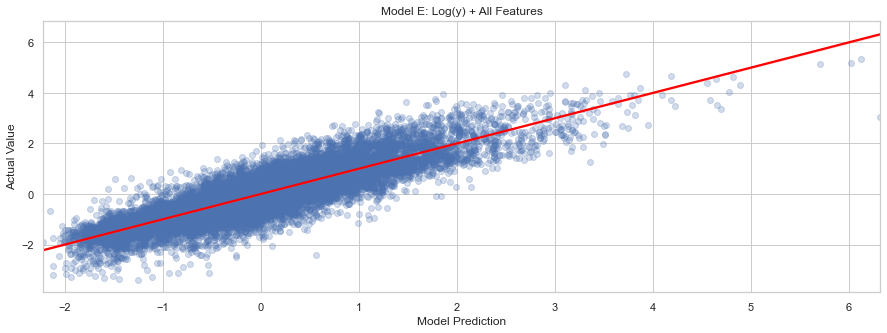

In [845]:
#plot y_hat
plt.figure(figsize = (15, 5))
sns.regplot(yhat, y, 
            line_kws = {'color': 'red'},
            scatter_kws = {'color':'b','alpha': 0.25},color='r')
plt.title('Model E: Log(y) + All Features')
plt.xlabel('Model Prediction')
plt.ylabel('Actual Value');
plt.savefig('./Data & Figures/model_E_scatterplot')

## Rank Features for Model E

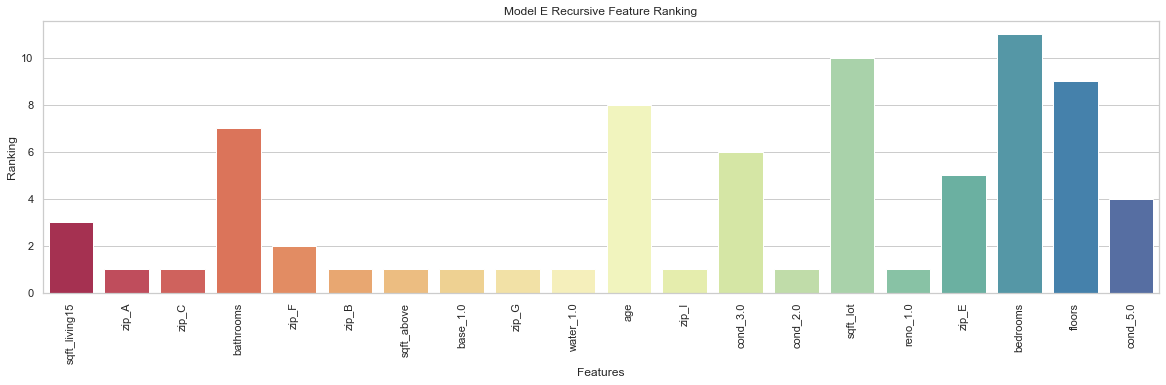

<Figure size 432x288 with 0 Axes>

In [846]:
linreg = LinearRegression()

#set number of features to be 10
selector = RFE(linreg, n_features_to_select = 10) 

#convert y to 1d np array to prevent DataConversionWarning
selector = selector.fit(X[result_E], y.values.ravel()) 
selector.support_

#plot features ranking
plt.figure(figsize = (20, 5))
sns.barplot(x = X[result_E].columns, y = selector.ranking_, palette = 'Spectral');
plt.title('Model E Recursive Feature Ranking')
plt.xlabel('Features')
plt.ylabel('Ranking')
plt.xticks(rotation = 90)
plt.show()
plt.savefig('./Data & Figures/model_E_recursive_features_elimination')

**Best Predictive Features:**

* 'zip_F'
* 'zip_H'
* 'zip_A'
* 'sqft_above'
* 'base_1.0'
* 'zip_D'
* 'zip_E'
* 'water_1.0'
* 'cond_2.0'
* 'zip_C'

## Test Model E

In [847]:
#recheck for multicollinearity
vif = [variance_inflation_factor(X[result_E].values, i) for i in range(X[result_E].shape[1])] 
list(zip(result_E, vif))

[('sqft_living15', 2.6321667678160554),
 ('zip_A', 4.327045799777062),
 ('zip_C', 1.8310948337327033),
 ('bathrooms', 24.630583822087676),
 ('zip_F', 1.4592026926268789),
 ('zip_B', 1.822161744074767),
 ('sqft_above', 3.179816567338986),
 ('base_1.0', 2.7835104558763684),
 ('zip_G', 1.597354012092623),
 ('water_1.0', 1.040045284368309),
 ('age', 2.2535175233433247),
 ('zip_I', 1.1872649337568888),
 ('cond_3.0', 4.023604547187554),
 ('cond_2.0', 1.0321601299834005),
 ('sqft_lot', 1.0729816227539868),
 ('reno_1.0', 1.1560418089432853),
 ('zip_E', 1.4476249307677223),
 ('bedrooms', 17.34506129572218),
 ('floors', 15.004779616449596),
 ('cond_5.0', 1.3350310372750631)]

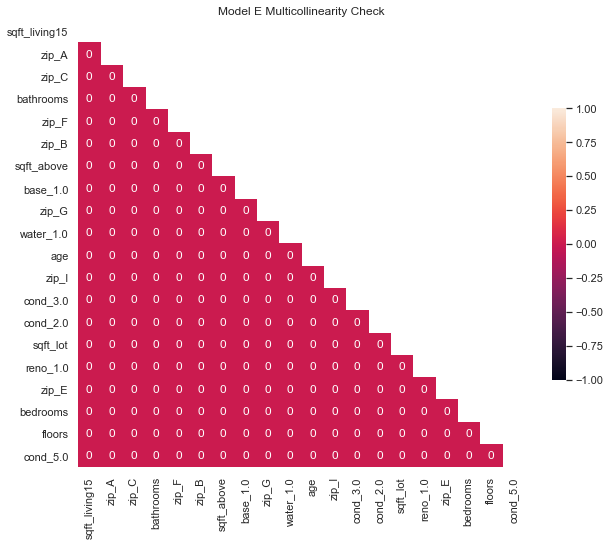

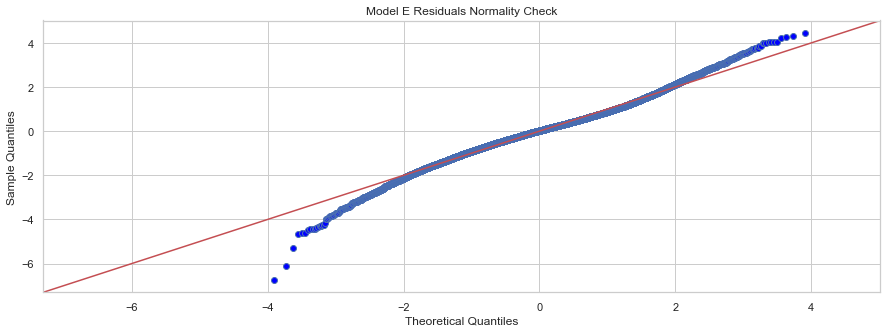

<Figure size 432x288 with 0 Axes>

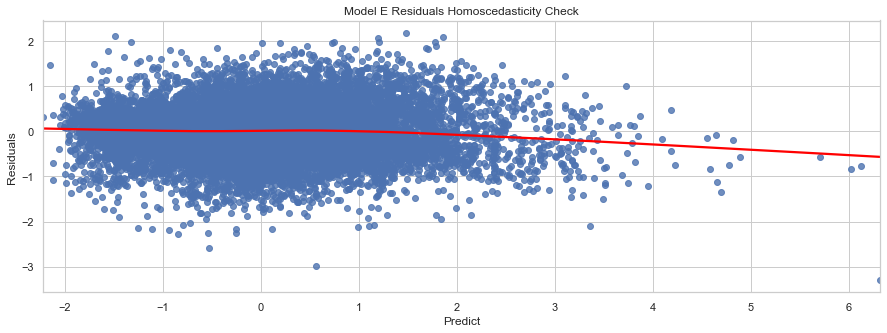

<Figure size 432x288 with 0 Axes>

In [848]:
#recheck for multicollinearity
mask = np.zeros_like(abs(X[result_E].corr()) > 0.75)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize = (10, 10))
    ax = sns.heatmap(abs(X[result_E].corr()) > 0.75, 
                     annot = True, 
                     ax = ax, 
                     cbar_kws = {"shrink": .5}, 
                     mask = mask, 
                     vmax = 1,
                     vmin = -1,
                     square = True)  
    plt.title('Model E Multicollinearity Check')
plt.savefig('./Data & Figures/model_E_multicollinearity_check')

#recheck for normality
fig = sm.graphics.qqplot(model_E.resid, 
                         dist = stats.norm, 
                         line = '45', 
                         fit = True)
fig.set_size_inches(15, 5)
plt.title('Model E Residuals Normality Check')
plt.show()
plt.savefig('./Data & Figures/model_E_residuals_qqplot')

#recheck for homoscedasticity
plt.figure(figsize = (15, 5))
sns.regplot(x = model_E.predict(), 
            y = model_E.resid, 
            lowess = True, 
            line_kws = {'color': 'red'})
plt.title('Model E Residuals Homoscedasticity Check')
plt.xlabel('Predict')
plt.ylabel('Residuals')
plt.show()
plt.savefig('./Data & Figures/model_E_homoscedasticity_regplot')

In [849]:
#Goldfeld-Quandt test
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(model_E.resid, model_E.model.exog)
list(zip(name, test))

[('F statistic', 1.0724825083856029), ('p-value', 0.000149090153783914)]

-0.24125728193800952


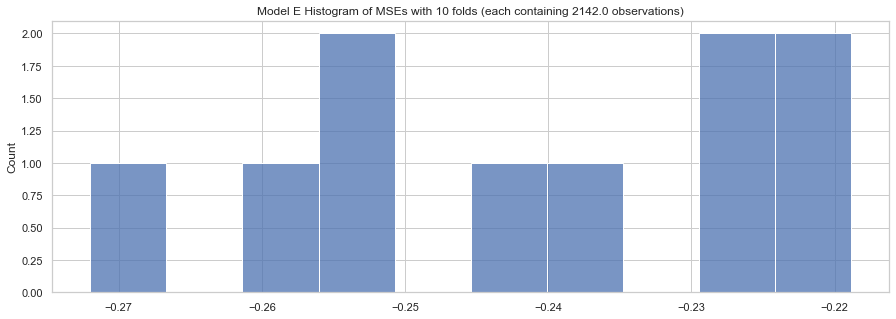

In [850]:
#cross-validation to check for overfitting
linreg = LinearRegression()

cv_result = cross_val_score(linreg, X[result_E], y, cv = 10, scoring = 'neg_mean_squared_error')
print(cv_result.mean())

#visualize the cv_result
folds = 10

plt.figure(figsize = (15, 5))
sns.histplot(cv_result, bins = 10);
plt.title('Model E Histogram of MSEs with {} folds (each containing {} observations)'
          .format(folds, round(len(preprocessed_log_E) / folds, 0)));
plt.savefig('./Data & Figures/model_E_cv_result_histplot')

In [851]:
#split the data into training and test sets. Use the default split size
X_train, X_test, y_train, y_test = train_test_split(X[result_E], y, test_size = 0.2, random_state = 42)
print(len(X_train), len(y_train), len(X_test), len(y_test))

linreg = LinearRegression()

#fit the model to train data
linreg.fit(X_train, y_train)

#calculate predictions on training and test sets
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

#calculate residuals (prediction - actual error)
train_residual = y_hat_train - y_train
test_residual = y_hat_test - y_test

train_rmse = mean_squared_error(y_train, y_hat_train, squared = False)
test_rmse = mean_squared_error(y_test, y_hat_test, squared = False)

print(train_rmse)
print(test_rmse)

17136 17136 4284 4284
0.4905295885170489
0.4796712201647737


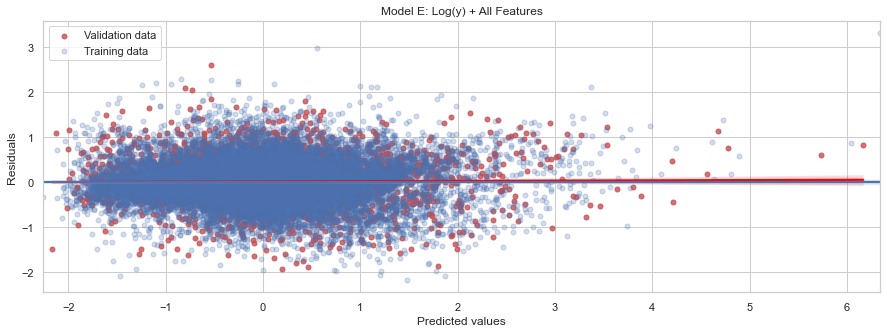

<Figure size 432x288 with 0 Axes>

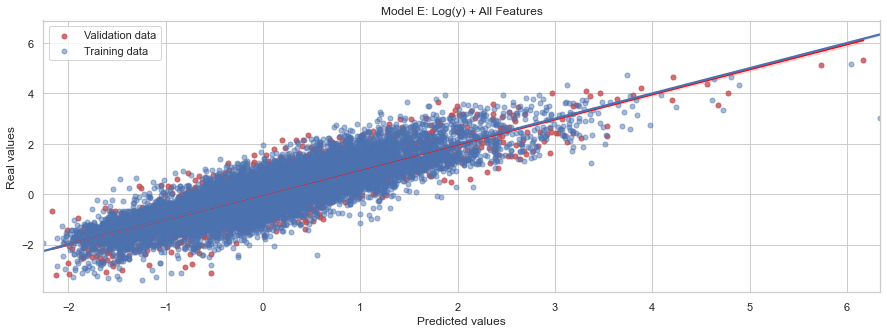

<Figure size 432x288 with 0 Axes>

In [852]:
#plot residuals: 
plt.figure(figsize = (15, 5))
sns.regplot(x = y_hat_test, y = y_hat_test - y_test,
            scatter_kws = {'s': 25}, 
            line_kws = {'color': 'red'},
            color = 'r',
            fit_reg = True, label = 'Validation data')
sns.regplot(x = y_hat_train, y = y_hat_train - y_train,
            scatter_kws = {'s': 25,'alpha': 0.25}, 
            fit_reg = True, label = 'Training data')

plt.title('Model E: Log(y) + All Features')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc = "upper left")
plt.show()
plt.savefig('./Data & Figures/model_E_residuals_regplot')

#plot predictions
plt.figure(figsize = (15, 5))
sns.regplot(x = y_hat_test, y = y_test, 
            line_kws = {'color': 'red'},
            scatter_kws = {'s': 25}, 
            color = 'r',
            fit_reg = True, label = 'Validation data')
sns.regplot(x = y_hat_train, y = y_train,  
                scatter_kws = {'s': 25,'alpha': 0.5}, fit_reg = True, label = 'Training data')

plt.title('Model E: Log(y) + All Features')
plt.xlabel('Predicted values')
plt.ylabel('Real values')
plt.legend(loc = 'upper left')
plt.show()
plt.savefig('./Data & Figures/model_E_predictions_regplot')

In [853]:
#get accuracy percentage
accuracy = linreg.score(X_test, y_test)
"Accuracy: {}%".format(int(round(accuracy * 100)))

'Accuracy: 77%'

In [854]:
#get bias/variance tradeoff

#transform with MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

#scale the train set
X_train_scaled = scaler.fit_transform(X_train)

#scale the test set
X_test_scaled = scaler.transform(X_test)

#training set predictions
lm_train_predictions = linreg.predict(X_train_scaled)

# Test set predictions 
lm_test_predictions = linreg.predict(X_test_scaled)

#bias and variance for training set 
b_train = bias(y_train, lm_train_predictions) 
v_train = variance(lm_train_predictions) 
print('Train bias: {} \nTrain variance: {}'.format(b_train, v_train))

#bias and variance for test set 
b_test = bias(y_test, lm_test_predictions) 
v_test = variance(lm_test_predictions) 
print('Test bias: {} \nTest variance: {}'.format(b_test, v_test))

Train bias: -0.12454426803103917 
Train variance: 0.2994831131111972
Test bias: -0.12015914721068585 
Test variance: 0.2936018827731668


In [855]:
#save model
tuple_objects = (linreg, X_train, y_train)
pickle.dump(tuple_objects, open('./Data & Figures/model_5.pkl','wb'))

In [856]:
summary_table_1.loc[4] = ['Model E', 'Log(y) + All features', len(result_E), 
                          r2_score(y, yhat), accuracy * 100, 
                          train_rmse, test_rmse,
                          b_train, b_test, v_train, v_test,
                          cv_result.mean(),
                          'P', 'P', 'P']
summary_table_1.head()

,Model,Description,Num Features,r2,Accuracy,RMSE Train,RMSE Test,Bias Train,Bias Test,Variance Train,Variance Test,Cross Validation,Multicollinearity,Normality,Homoscedasticity
0,Model A,All features,19.0,0.668177,66.236718,0.562527,0.628671,0.186644,0.179878,0.210681,0.205261,-0.336890,P,F,F
1,Model B,"All features, outliers removed, RFE",10.0,0.642821,63.983660,0.535751,0.536075,0.169684,0.163239,0.208434,0.209862,-0.289727,P,F,F
2,Model C,All features + Polynomial Regression,19.0,0.585625,56.964942,0.574945,0.585986,-1.227318,-1.227659,0.154362,0.155297,-0.337742,P,F,F
3,Model D,All features + Log(X),17.0,0.578698,55.904542,0.630884,0.718453,0.217138,0.210314,0.172343,0.169893,-0.425037,P,F,F
4,Model E,Log(y) + All features,20.0,0.761546,77.325163,0.490530,0.479671,-0.124544,-0.120159,0.299483,0.293602,-0.241257,P,P,P


In [857]:
#save
summary_table_1.to_csv('./Data & Figures/summary_table_1')

# MODEL F
## Interactions 

In [858]:
preprocessed_log_F = clean[['price_log', 
                            'sqft_above', 'sqft_lot', 'sqft_living15',
                            'age', 'bedrooms', 'bathrooms', 'floors',
                            'water_1.0', 'base_1.0', 'reno_1.0',
                            'cond_2.0', 'cond_3.0', 'cond_5.0',
                            'zip_A', 'zip_B', 'zip_C', 'zip_E', 'zip_D', 'zip_F', 'zip_G', 'zip_H', 'zip_I']]

preprocessed_log_F.head()

,price_log,sqft_above,sqft_lot,sqft_living15,age,bedrooms,bathrooms,floors,water_1.0,base_1.0,...,cond_5.0,zip_A,zip_B,zip_C,zip_E,zip_D,zip_F,zip_G,zip_H,zip_I
15937,-1.044412,-1.099527,-0.169225,-1.441766,0.955962,3,1.00,1.0,0,1,...,0,0,0,0,1,0,0,0,0,0
20963,-0.288860,-1.075393,-0.340062,-0.799934,-1.357975,2,1.75,1.5,0,1,...,0,0,0,0,0,0,0,1,0,0
7614,-0.603535,-1.292602,-0.264865,-0.697824,0.989991,3,1.00,1.0,0,1,...,0,1,0,0,0,0,0,0,0,0
3257,-0.386080,-1.147796,-0.186754,-0.085165,1.092076,2,1.00,1.0,0,1,...,1,1,0,0,0,0,0,0,0,0
16723,-0.462787,-0.230689,-0.263901,-1.164611,1.500418,5,2.00,1.5,0,0,...,0,1,0,0,0,0,0,0,0,0


In [859]:
#define training variables
X = preprocessed_log_F.drop(['price_log'], axis = 1)
y = preprocessed_log_F['price_log']

In [860]:
#get baseline model r2
from sklearn.model_selection import KFold

linreg = LinearRegression()

crossvalidation = KFold(n_splits = 10, shuffle = True, random_state =1)

baseline = np.mean(cross_val_score(linreg, X, y, scoring = 'r2', cv = crossvalidation))
baseline

0.7606072097877115

In [861]:
from itertools import combinations

interactions = []

feat_combinations = combinations(X.columns, 2)

data = X.copy()
for i, (a, b) in enumerate(feat_combinations):
    data['interaction'] = data[a] * data[b]
    score = np.mean(cross_val_score(linreg, data, y, scoring='r2', cv = crossvalidation))
    if score > baseline:
        interactions.append((a, b, round(score,3)))
    
    if i % 50 == 0:
        print(i)
            
print('Top 10 interactions: %s' %sorted(interactions, key = lambda inter: inter[2], reverse = True)[:10])

0
50
100
150
200
Top 10 interactions: [('sqft_above', 'sqft_living15', 0.769), ('sqft_living15', 'age', 0.767), ('sqft_living15', 'floors', 0.767), ('sqft_above', 'bedrooms', 0.764), ('sqft_above', 'floors', 0.764), ('sqft_above', 'zip_A', 0.764), ('sqft_living15', 'bathrooms', 0.764), ('sqft_living15', 'cond_3.0', 0.764), ('sqft_living15', 'zip_A', 0.764), ('sqft_above', 'bathrooms', 0.763)]


In [862]:
#check how many pairs of interaction there are
len(interactions)

139

In [863]:
sorted(interactions, key = lambda inter: inter[2], reverse = True)[:10]

[('sqft_above', 'sqft_living15', 0.769),
 ('sqft_living15', 'age', 0.767),
 ('sqft_living15', 'floors', 0.767),
 ('sqft_above', 'bedrooms', 0.764),
 ('sqft_above', 'floors', 0.764),
 ('sqft_above', 'zip_A', 0.764),
 ('sqft_living15', 'bathrooms', 0.764),
 ('sqft_living15', 'cond_3.0', 0.764),
 ('sqft_living15', 'zip_A', 0.764),
 ('sqft_above', 'bathrooms', 0.763)]

In [864]:
#use 10-fold cross-validation to build a model using the above interaction
regression = LinearRegression()
crossvalidation = KFold(n_splits = 10, shuffle = True, random_state = 1)
X_interactions = X.copy()

X_interactions['sqft_above * sqft_living15'] = X_interactions['sqft_above'] * X_interactions['sqft_living15']
X_interactions['sqft_living15 * age'] = X_interactions['sqft_living15'] * X_interactions['age']
X_interactions['sqft_living15 * floors'] = X_interactions['sqft_living15'] * X_interactions['floors']
X_interactions['sqft_above * bedrooms'] = X_interactions['sqft_above'] * X_interactions['bedrooms']
X_interactions['sqft_above * floors'] = X_interactions['sqft_above'] * X_interactions['floors']
X_interactions['sqft_above * zip_A'] = X_interactions['sqft_above'] * X_interactions['zip_A']
X_interactions['sqft_living15 * bathrooms'] = X_interactions['sqft_living15'] * X_interactions['bathrooms']
X_interactions['sqft_living15 * cond_3.0'] = X_interactions['sqft_living15'] * X_interactions['cond_3.0']
X_interactions['sqft_living15 * zip_A'] = X_interactions['sqft_living15'] * X_interactions['zip_A']
X_interactions['sqft_above * bathrooms'] = X_interactions['sqft_above'] * X_interactions['bathrooms']

interaction_model = np.mean(cross_val_score(regression, X_interactions, y, scoring = 'r2', cv = crossvalidation))

interaction_model

0.7736236389793466

In [865]:
#drop p-value > 0.05
X_interactions.drop('sqft_above', axis = 1, inplace = True)

In [866]:
#drop p-value > 0.05
X_interactions.drop('zip_B', axis = 1, inplace = True)

In [867]:
#apply stepwise function
result_F = stepwise_selection(X_interactions, y, verbose=True)
print('Resulting Features:')
print(result_F)

Add  sqft_living15                  with p-value 0.0
Add  zip_A                          with p-value 0.0
Add  zip_C                          with p-value 0.0
Add  sqft_above * floors            with p-value 0.0
Add  bathrooms                      with p-value 0.0
Add  zip_F                          with p-value 0.0
Add  zip_H                          with p-value 8.12739e-235
Add  zip_D                          with p-value 0.0
Add  base_1.0                       with p-value 1.72115e-184
Add  sqft_living15 * floors         with p-value 1.86841e-216
Add  zip_E                          with p-value 6.58906e-205
Add  age                            with p-value 2.55335e-227
Add  water_1.0                      with p-value 1.52731e-207
Add  sqft_living15 * age            with p-value 8.78847e-68
Add  zip_I                          with p-value 4.39215e-41
Add  sqft_above * sqft_living15     with p-value 5.14257e-37
Add  cond_3.0                       with p-value 3.33842e-30
Add  cond_2.0

## Build Model F

In [868]:
#create model in OLS
X_int = sm.add_constant(X_interactions[result_F])
model_F = sm.OLS(y, X_interactions[result_F]).fit()

model_F.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              price_log   R-squared (uncentered):                   0.767
Model:                            OLS   Adj. R-squared (uncentered):              0.766
Method:                 Least Squares   F-statistic:                              2509.
Date:                Wed, 03 Feb 2021   Prob (F-statistic):                        0.00
Time:                        00:12:34   Log-Likelihood:                         -14810.
No. Observations:               21420   AIC:                                  2.968e+04
Df Residuals:                   21392   BIC:                                  2.990e+04
Df Model:                          28                                                  
Covariance Type:            nonrobust                                                  
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
sqft_living15                  0.5983      0.018     32.809      0.000       0.563       0.634
zip_A                          0.2191      0.013     17.176      0.000       0.194       0.244
zip_C                          0.0832      0.013      6.419      0.000       0.058       0.109
sqft_above * floors            0.2121      0.009     24.563      0.000       0.195       0.229
bathrooms                      0.1609      0.007     21.963      0.000       0.147       0.175
zip_F                         -1.0667      0.015    -72.898      0.000      -1.095      -1.038
zip_H                         -0.8678      0.015    -56.325      0.000      -0.898      -0.838
zip_D                         -0.8848      0.015    -59.281      0.000      -0.914      -0.855
base_1.0                       0.2804      0.009     31.788      0.000       0.263       0.298
sqft_living15 * floors        -0.1906      0.010    -19.441      0.000      -0.210      -0.171
zip_E                         -0.7215      0.016    -44.643      0.000      -0.753      -0.690
age                            0.0940      0.005     18.021      0.000       0.084       0.104
water_1.0                      1.2124      0.041     29.613      0.000       1.132       1.293
sqft_living15 * age            0.0248      0.005      5.051      0.000       0.015       0.034
zip_I                         -0.3737      0.022    -17.222      0.000      -0.416      -0.331
sqft_above * sqft_living15    -0.0532      0.004    -13.183      0.000      -0.061      -0.045
cond_3.0                      -0.1134      0.008    -13.555      0.000      -0.130      -0.097
cond_2.0                      -0.4639      0.039    -11.993      0.000      -0.540      -0.388
bedrooms                      -0.0669      0.004    -16.573      0.000      -0.075      -0.059
sqft_above * zip_A             0.1072      0.010     10.919      0.000       0.088       0.126
sqft_lot                       0.0336      0.003      9.669      0.000       0.027       0.040
reno_1.0                       0.1817      0.019      9.457      0.000       0.144       0.219
cond_5.0                       0.1036      0.014      7.595      0.000       0.077       0.130
zip_G                         -0.1296      0.014     -9.043      0.000      -0.158      -0.102
floors                         0.0285      0.008      3.493      0.000       0.013       0.045
sqft_living15 * cond_3.0      -0.0355      0.009     -4.159      0.000      -0.052      -0.019
sqft_living15 * bathrooms      0.0174      0.006      3.077      0.002       0.006       0.029
sqft_above * bedrooms          0.0156      0.004      4.248      0.000       0.008       0.023
=======================================

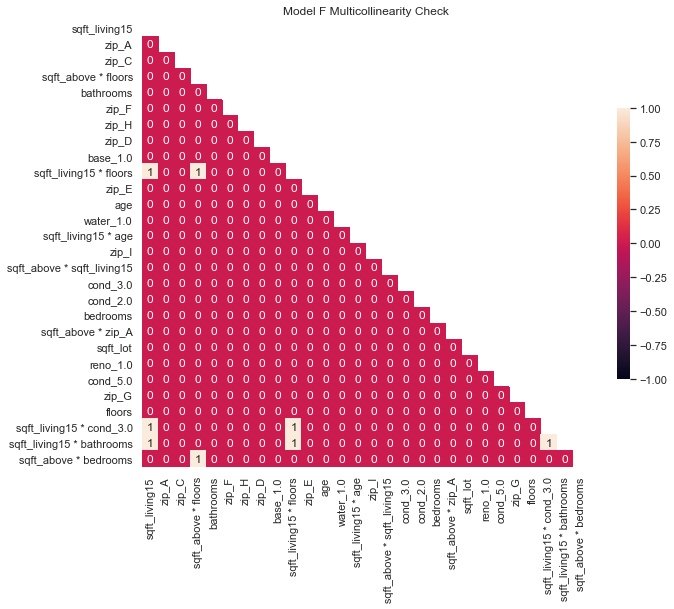

In [869]:
#recheck for multicollinearity
mask = np.zeros_like(abs(X_interactions[result_F].corr()) > 0.75)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize = (10, 10))
    ax = sns.heatmap(abs(X_interactions[result_F].corr()) > 0.75, 
                     annot = True, 
                     ax = ax, 
                     cbar_kws = {"shrink": .5}, 
                     mask = mask, 
                     vmax = 1,
                     vmin = -1,
                     square = True)  
    plt.title('Model F Multicollinearity Check')
plt.savefig('./Data & Figures/model_F_multicollinearity_check')

In [870]:
#that have correlations over .75, but less than 1 
X_interactions_cor = X_interactions.corr().abs().stack().reset_index().sort_values(0, ascending = False)
X_interactions_cor['pairs'] = list(zip(X_interactions_cor['level_0'], X_interactions_cor['level_1']))
X_interactions_cor.set_index(['pairs'], inplace = True)
X_interactions_cor.drop(columns = ['level_0', 'level_1'], inplace = True)

#add correlation column
X_interactions_cor.columns = ['cc']

#drop duplicates
X_interactions_cor.drop_duplicates(inplace = True)

#correlations over .75, but less than 1. = multicollinarity
X_interactions_cor[(X_interactions_cor['cc'] > 0.75) & (X_interactions_cor['cc'] < 1)]

X_interactions_cor.head(11)

,cc
pairs,
"(sqft_lot, sqft_lot)",1.000000
"(sqft_above * floors, sqft_above * bedrooms)",0.961762
"(sqft_living15 * floors, sqft_living15)",0.956398
"(sqft_above * bathrooms, sqft_above * bedrooms)",0.954756
"(sqft_living15 * bathrooms, sqft_living15 * floors)",0.943060
"(sqft_above * floors, sqft_above * bathrooms)",0.941240
"(sqft_living15 * bathrooms, sqft_living15)",0.936233
"(sqft_living15 * cond_3.0, sqft_living15 * floors)",0.860944
"(sqft_living15, sqft_living15 * cond_3.0)",0.847033


In [871]:
#drop multicollinearity
X_interactions.drop(['sqft_living15 * bathrooms', 'sqft_living15 * floors', 'sqft_living15 * cond_3.0',
                     'sqft_above * bathrooms', 'sqft_above * floors', 'sqft_above * bedrooms'], axis = 1, inplace = True)

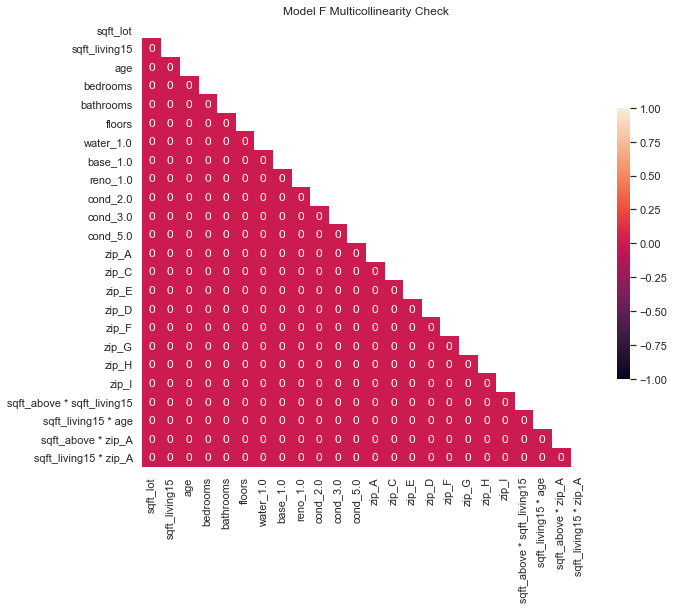

In [872]:
#recheck for multicollinearity
mask = np.zeros_like(abs(X_interactions.corr()) > 0.75)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize = (10, 10))
    ax = sns.heatmap(abs(X_interactions.corr()) > 0.75, 
                     annot = True, 
                     ax = ax, 
                     cbar_kws = {"shrink": .5}, 
                     mask = mask, 
                     vmax = 1,
                     vmin = -1,
                     square = True)  
    plt.title('Model F Multicollinearity Check')
plt.savefig('./Data & Figures/model_F_multicollinearity_check')

## Re-build Model F

In [873]:
#drop p-value > 0.05
X_interactions.drop('sqft_living15', axis = 1, inplace = True)

In [874]:
#re-apply stepwise function
result_F = stepwise_selection(X_interactions, y, verbose=True)
print('Resulting Features:')
print(result_F)

Add  zip_C                          with p-value 0.0
Add  sqft_above * sqft_living15     with p-value 0.0
Add  zip_A                          with p-value 0.0
Add  sqft_living15 * zip_A          with p-value 0.0
Add  bedrooms                       with p-value 0.0
Add  floors                         with p-value 0.0
Add  zip_F                          with p-value 0.0
Add  bathrooms                      with p-value 0.0
Add  zip_D                          with p-value 1.05328e-273
Add  zip_H                          with p-value 0.0
Add  zip_E                          with p-value 0.0
Add  water_1.0                      with p-value 1.07144e-221
Add  age                            with p-value 1.2657e-135
Add  sqft_lot                       with p-value 6.17529e-95
Add  zip_I                          with p-value 1.85318e-64
Add  base_1.0                       with p-value 1.19189e-46
Add  sqft_above * zip_A             with p-value 2.67281e-48
Add  sqft_living15 * age            with 

In [875]:
X_int = sm.add_constant(X_interactions[result_F])
model_F = sm.OLS(y, X_interactions[result_F]).fit()

model_F.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              price_log   R-squared (uncentered):                   0.643
Model:                            OLS   Adj. R-squared (uncentered):              0.643
Method:                 Least Squares   F-statistic:                              1753.
Date:                Wed, 03 Feb 2021   Prob (F-statistic):                        0.00
Time:                        00:12:42   Log-Likelihood:                         -19358.
No. Observations:               21420   AIC:                                  3.876e+04
Df Residuals:                   21398   BIC:                                  3.893e+04
Df Model:                          22                                                  
Covariance Type:            nonrobust                                                  
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
zip_C                          0.0117      0.016      0.740      0.459      -0.019       0.043
sqft_above * sqft_living15     0.0799      0.003     26.683      0.000       0.074       0.086
zip_A                          0.0782      0.016      4.960      0.000       0.047       0.109
sqft_living15 * zip_A          0.4310      0.012     35.048      0.000       0.407       0.455
bedrooms                      -0.0788      0.005    -15.922      0.000      -0.089      -0.069
floors                         0.0351      0.010      3.493      0.000       0.015       0.055
zip_F                         -1.4682      0.018    -83.785      0.000      -1.503      -1.434
bathrooms                      0.3376      0.009     38.864      0.000       0.321       0.355
zip_D                         -1.2954      0.018    -72.477      0.000      -1.330      -1.260
zip_H                         -1.2574      0.019    -67.793      0.000      -1.294      -1.221
zip_E                         -1.2222      0.019    -63.878      0.000      -1.260      -1.185
water_1.0                      1.4934      0.050     29.598      0.000       1.394       1.592
age                           -0.0260      0.006     -4.122      0.000      -0.038      -0.014
sqft_lot                       0.0959      0.004     22.693      0.000       0.088       0.104
zip_I                         -0.6907      0.027    -25.942      0.000      -0.743      -0.638
base_1.0                       0.1537      0.010     15.025      0.000       0.134       0.174
sqft_above * zip_A             0.3720      0.012     31.077      0.000       0.349       0.396
sqft_living15 * age           -0.0975      0.005    -17.799      0.000      -0.108      -0.087
cond_2.0                      -0.6928      0.048    -14.566      0.000      -0.786      -0.600
cond_3.0                      -0.1958      0.010    -20.267      0.000      -0.215      -0.177
reno_1.0                       0.2843      0.024     11.996      0.000       0.238       0.331
zip_G                         -0.2888      0.018    -16.423      0.000      -0.323      -0.254
==============================================================================
Omnibus:                      545.017   Durbin-Watson:                   1.076
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1288.663
Skew:                          -0.069   Prob(JB):                    1.48e-280
Kurtosis:                       4.194   Cond. No.                         56.5
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that 

In [876]:
#create linear regression object
linreg = LinearRegression()

#fit model
linreg.fit(X_interactions[result_F], y)

#predict yhat using our model
yhat = linreg.predict(X_interactions[result_F])
yhat

array([-0.94433083, -0.18483247, -0.36846534, ..., -1.31594991,
       -0.79073215, -0.52781554])

In [877]:
#get intercept
linreg.intercept_

-1.141863839966562

In [878]:
#get coefficients and sort them
coefficients_F = dict(zip(X_interactions[result_F], list(linreg.coef_)))
dict(sorted(coefficients_F.items(), key = lambda item: item[1]))

{'zip_F': -1.2068390172139898,
 'zip_D': -1.0473669991764134,
 'zip_H': -1.0015328177824832,
 'zip_E': -0.9402836888460581,
 'cond_2.0': -0.5438972438765398,
 'zip_I': -0.4759194536831429,
 'zip_G': -0.11022785902831096,
 'cond_3.0': -0.09342946855202934,
 'sqft_living15 * age': -0.08009410621554372,
 'bedrooms': 0.04650144804190555,
 'sqft_above * sqft_living15': 0.07241470904568104,
 'age': 0.07790257201022002,
 'sqft_lot': 0.09625115575963887,
 'base_1.0': 0.1725543652610324,
 'reno_1.0': 0.18090002345913248,
 'sqft_above * zip_A': 0.18605461387653088,
 'zip_A': 0.18607980195919185,
 'zip_C': 0.20496855496608285,
 'floors': 0.21725575277827214,
 'bathrooms': 0.4185600540388919,
 'sqft_living15 * zip_A': 0.4189329299388109,
 'water_1.0': 1.4859653117700502}

In [879]:
lists_F = sorted(coefficients_F.items(), key = lambda item: item[1])
a, b = zip(*lists_F)
fig = go.Figure(go.Waterfall(x  = a, y = b, 
                             name = "coefficients"))
fig.update_layout(title = 'Model F Coefficients',
                  showlegend = True)
fig.update_xaxes(title_text = 'Features', tickangle = 90)
fig.update_yaxes(title_text = 'Coefficients')
fig.show()
#fig.write_image('./Data & Figures/model_F_waterfall.png')

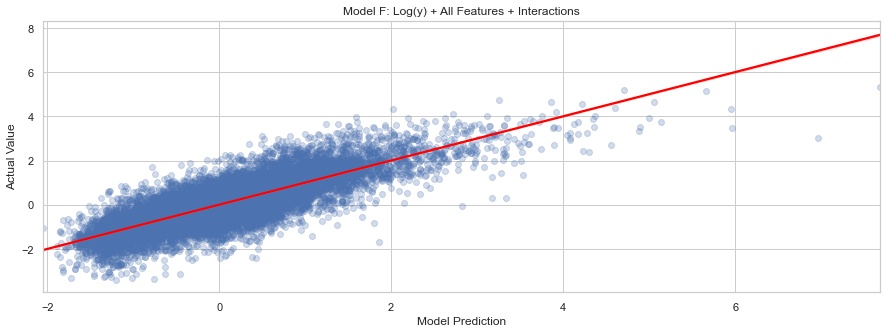

In [880]:
#plot y_hat
plt.figure(figsize = (15, 5))
sns.regplot(yhat, y, scatter_kws = {'color':'b','alpha': 0.25}, line_kws = {'color': 'red'})
plt.title('Model F: Log(y) + All Features + Interactions')
plt.xlabel('Model Prediction')
plt.ylabel('Actual Value');
plt.savefig('./Data & Figures/model_F_scatterplot')

## Rank Features for Model F

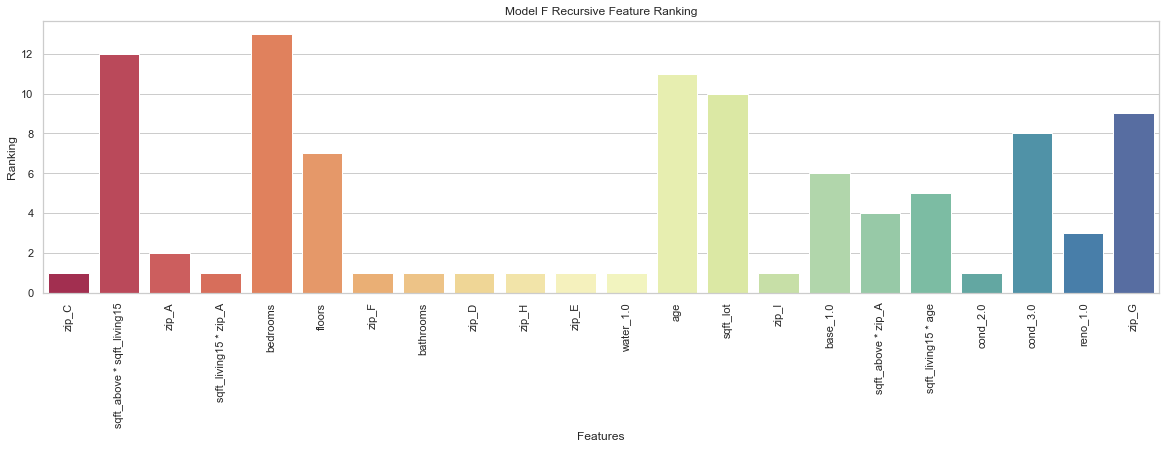

<Figure size 432x288 with 0 Axes>

In [881]:
linreg = LinearRegression()

#set number of features to be 10
selector = RFE(linreg, n_features_to_select = 10) 

#convert y to 1d np array to prevent DataConversionWarning
selector = selector.fit(X_interactions[result_F], y.values.ravel()) 
selector.support_

#plot features ranking
plt.figure(figsize = (20, 5))
sns.barplot(x = X_interactions[result_F].columns, y = selector.ranking_, palette = 'Spectral');
plt.title('Model F Recursive Feature Ranking')
plt.xlabel('Features')
plt.ylabel('Ranking')
plt.xticks(rotation = 90)
plt.show()
plt.savefig('./Data & Figures/model_F_recursive_features_elimination')

**Best Predictive Features:**

* 'zip_F'
* 'sqft_living15 * zip_A'
* 'zip_H'
* 'bathrooms'
* 'zip_E'
* 'zip_D'
* 'water_1.0'
* 'zip_I'
* 'zip_C'
* 'cond_2.0'

## Re-test Model F

In [882]:
#recheck for multicollinearity
vif = [variance_inflation_factor(X_interactions[result_F].values, i) for i in range(X_interactions[result_F].shape[1])] 
list(zip(result_F, vif))

[('zip_C', 1.8271982807373184),
 ('sqft_above * sqft_living15', 1.8221129918049894),
 ('zip_A', 5.129904824843243),
 ('sqft_living15 * zip_A', 2.29564338146412),
 ('bedrooms', 17.913768852943672),
 ('floors', 15.277431898207075),
 ('zip_F', 1.4389954521496122),
 ('bathrooms', 22.976366455614645),
 ('zip_D', 1.4451576899679848),
 ('zip_H', 1.409802494241986),
 ('zip_E', 1.4112118548905621),
 ('water_1.0', 1.040486783205706),
 ('age', 2.380122211773886),
 ('sqft_lot', 1.07080163570844),
 ('zip_I', 1.1944835487628012),
 ('base_1.0', 2.468080489082674),
 ('sqft_above * zip_A', 2.152370811615895),
 ('sqft_living15 * age', 1.885583887709295),
 ('cond_2.0', 1.0260298420919935),
 ('cond_3.0', 3.632628057350531),
 ('reno_1.0', 1.1635556851249196),
 ('zip_G', 1.590533425859102)]

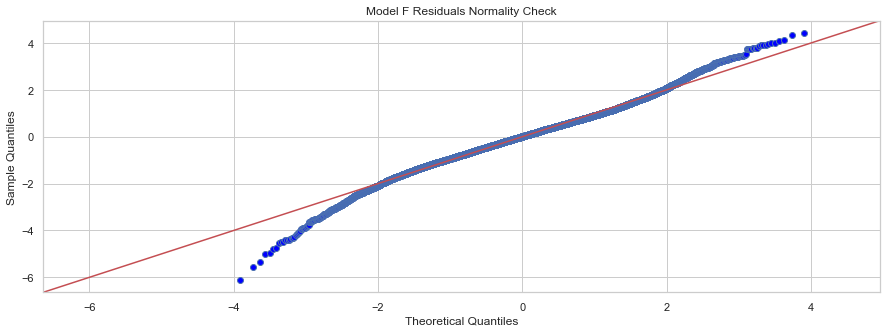

<Figure size 432x288 with 0 Axes>

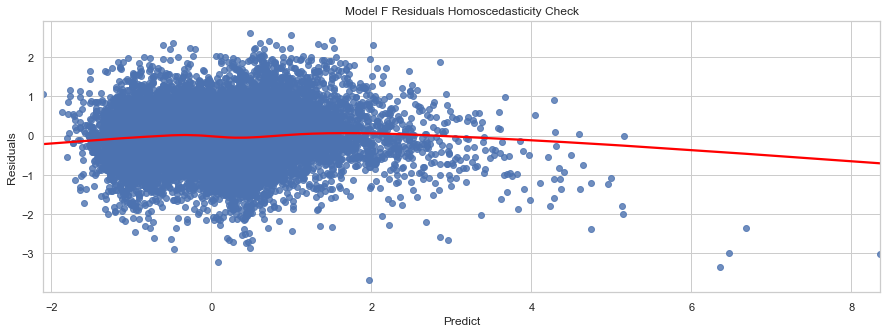

<Figure size 432x288 with 0 Axes>

In [883]:
#recheck for normality
fig = sm.graphics.qqplot(model_F.resid, 
                         dist = stats.norm, 
                         line = '45', 
                         fit = True)
fig.set_size_inches(15, 5)
plt.title('Model F Residuals Normality Check')
plt.show()
plt.savefig('./Data & Figures/model_F_residuals_qqplot')

#recheck for homoscedasticity
plt.figure(figsize = (15, 5))
sns.regplot(x = model_F.predict(), 
            y = model_F.resid, 
            lowess = True, 
            line_kws = {'color': 'red'})
plt.title('Model F Residuals Homoscedasticity Check')
plt.xlabel('Predict')
plt.ylabel('Residuals')
plt.show()
plt.savefig('./Data & Figures/model_F_homoscedasticity_regplot')

In [884]:
#Goldfeld-Quandt test
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(model_F.resid, model_F.model.exog)
list(zip(name, test))

[('F statistic', 1.0860439805491966), ('p-value', 9.95083289381627e-06)]

-0.3262182340448543


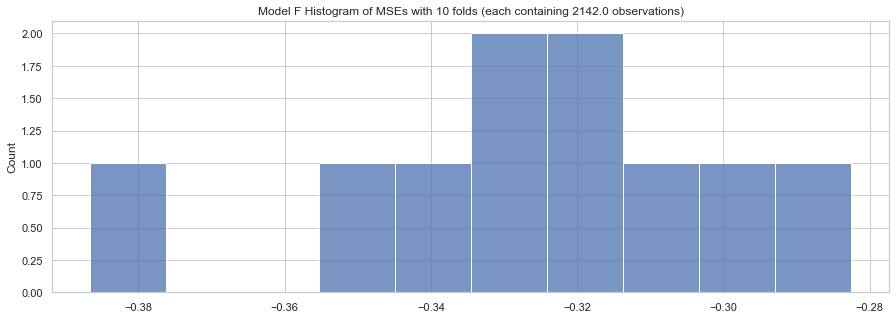

In [885]:
#cross-validation to check for overfitting
linreg = LinearRegression()

cv_result = cross_val_score(linreg, X_interactions[result_F], y, cv = 10, scoring = 'neg_mean_squared_error')
print(cv_result.mean())

#visualize the cv_result
folds = 10

plt.figure(figsize = (15, 5))
sns.histplot(cv_result, bins = 10);
plt.title('Model F Histogram of MSEs with {} folds (each containing {} observations)'
          .format(folds, round(len(preprocessed_log_F) / folds, 0)));
plt.savefig('./Data & Figures/model_F_cv_result_histplot')

## Validate Model F

In [886]:
#split the data into training and test sets. Use the default split size
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_interactions[result_F], y, test_size = 0.20, random_state = 42)
print(len(X_train), len(y_train), len(X_test), len(y_test))

#import and initialize the linear regression model class
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()

#fit the model to train data
linreg.fit(X_train, y_train)

#calculate predictions on training and test sets
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

#calculate residuals
train_residual = y_hat_train - y_train
test_residual = y_hat_test - y_test

#calculate training and test MSE
from sklearn.metrics import mean_squared_error

train_rmse = mean_squared_error(y_train, y_hat_train, squared = False)
test_rmse = mean_squared_error(y_test, y_hat_test, squared = False)

print(train_rmse)
print(test_rmse)

17136 17136 4284 4284
0.5699848810686948
0.5609758316975474


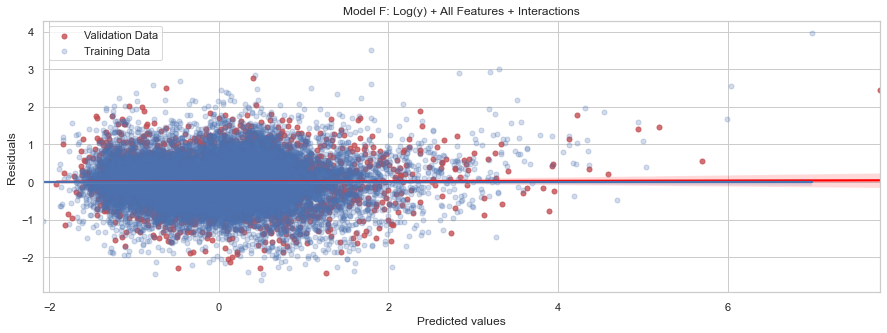

<Figure size 432x288 with 0 Axes>

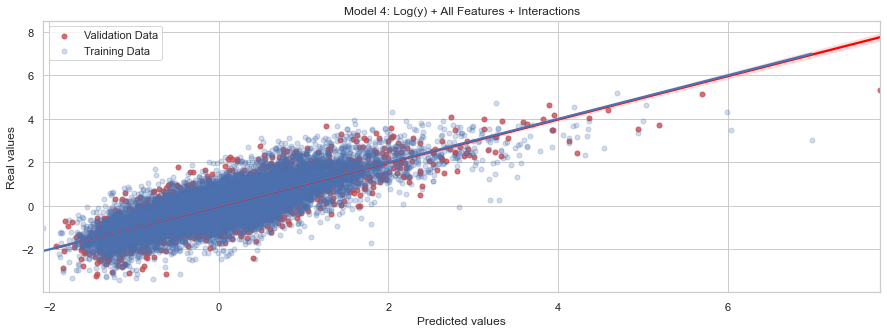

<Figure size 432x288 with 0 Axes>

In [887]:
#plot residuals: 
plt.figure(figsize = (15, 5))
sns.regplot(x = y_hat_test, y = y_hat_test - y_test,
            scatter_kws = {'s': 25}, line_kws = {'color': 'red'}, color = 'r', fit_reg = True, label = 'Validation Data')
sns.regplot(x = y_hat_train, y = y_hat_train - y_train,
            scatter_kws = {'s': 25,'alpha': 0.25}, fit_reg = True, label = 'Training Data')


plt.title('Model F: Log(y) + All Features + Interactions')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc = 'upper left')
plt.show()
plt.savefig('./Data & Figures/model_F_residuals_regplot')

#plot predictions
plt.figure(figsize = (15, 5))
sns.regplot(x = y_hat_test, y = y_test,
            scatter_kws = {'s': 25}, line_kws = {'color': 'red'}, color = 'r', fit_reg = True, label = 'Validation Data')
sns.regplot(x = y_hat_train, y = y_train,
            scatter_kws = {'s': 25,'alpha':0.25}, fit_reg = True, label = 'Training Data')

plt.title('Model 4: Log(y) + All Features + Interactions')
plt.xlabel('Predicted values')
plt.ylabel('Real values')
plt.legend(loc = 'upper left')
plt.show()
plt.savefig('./Data & Figures/model_F_predictions_regplot')

In [888]:
#get accuracy percentage
accuracy = linreg.score(X_test, y_test)
"Accuracy: {}%".format(int(round(accuracy * 100)))

'Accuracy: 69%'

In [889]:
#get bias/variance tradeoff

#transform with MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

#scale the train set
X_train_scaled = scaler.fit_transform(X_train)

#scale the test set
X_test_scaled = scaler.transform(X_test)

#training set predictions
lm_train_predictions = linreg.predict(X_train_scaled)

# Test set predictions 
lm_test_predictions = linreg.predict(X_test_scaled)

#bias and variance for training set 
b_train = bias(y_train, lm_train_predictions) 
v_train = variance(lm_train_predictions) 
print('Train bias: {} \nTrain variance: {}'.format(b_train, v_train))

#bias and variance for test set 
b_test = bias(y_test, lm_test_predictions) 
v_test = variance(lm_test_predictions) 
print('Test bias: {} \nTest variance: {}'.format(b_test, v_test))

Train bias: -1.0272248037254181 
Train variance: 0.3471091357291658
Test bias: -1.0240977814078918 
Test variance: 0.3414716285380901


In [890]:
#save model
tuple_objects = (linreg, X_train, y_train)
pickle.dump(tuple_objects, open('./Data & Figures/model_F.pkl','wb'))

In [891]:
#update summary
summary_table_1.loc[5] = ['Model F', 'Log(y) + All features + Interactions', len(result_F) - 2, 
                          r2_score(y, yhat), accuracy * 100, 
                          train_rmse, test_rmse,
                          b_train, b_test, v_train, v_test,
                          cv_result.mean(),
                          'P', 'P', 'P']
summary_table_1.head(10)

,Model,Description,Num Features,r2,Accuracy,RMSE Train,RMSE Test,Bias Train,Bias Test,Variance Train,Variance Test,Cross Validation,Multicollinearity,Normality,Homoscedasticity
0,Model A,All features,19.0,0.668177,66.236718,0.562527,0.628671,0.186644,0.179878,0.210681,0.205261,-0.336890,P,F,F
1,Model B,"All features, outliers removed, RFE",10.0,0.642821,63.983660,0.535751,0.536075,0.169684,0.163239,0.208434,0.209862,-0.289727,P,F,F
2,Model C,All features + Polynomial Regression,19.0,0.585625,56.964942,0.574945,0.585986,-1.227318,-1.227659,0.154362,0.155297,-0.337742,P,F,F
3,Model D,All features + Log(X),17.0,0.578698,55.904542,0.630884,0.718453,0.217138,0.210314,0.172343,0.169893,-0.425037,P,F,F
4,Model E,Log(y) + All features,20.0,0.761546,77.325163,0.490530,0.479671,-0.124544,-0.120159,0.299483,0.293602,-0.241257,P,P,P
5,Model F,Log(y) + All features + Interactions,20.0,0.677239,68.986902,0.569985,0.560976,-1.027225,-1.024098,0.347109,0.341472,-0.326218,P,P,P


In [892]:
#save
summary_table_1.to_csv('./Data & Figures/summary_table_1')

# BEST FIT MODEL: MODEL E

With the linear regression, we would interpret log transformed variables as a percentage change. (https://data.library.virginia.edu/interpreting-log-transformations-in-a-linear-model/)

* **Only the dependent/response variable y is log-transformed:** 

Exponentiate the coefficient, subtract one from this number, and multiply by 100. This gives the percent increase (or decrease) in the response for every one-unit increase in the independent variable. Example: the coefficient is 0.198. (exp(0.198) – 1) * 100 = 21.9. For every one-unit increase in the independent variable, our dependent variable increases by about 22%.

* **Only independent/predictor variable(s) X is log-transformed:** 

Divide the coefficient by 100. This tells us that a 1% increase in the independent variable increases (or decreases) the dependent variable by (coefficient/100) units. Example: the coefficient is 0.198. 0.198/100 = 0.00198. For every 1% increase in the independent variable, our dependent variable increases by about 0.002. For x percent increase, multiply the coefficient by log(1.x). Example: For every 10% increase in the independent variable, our dependent variable increases by about 0.198 * log(1.10) = 0.02.

* **Both dependent/response variable y and independent/predictor variable(s) X are log-transformed:** 

Interpret the coefficient as the percent increase in the dependent variable for every 1% increase in the independent variable. Example: the coefficient is 0.198. For every 1% increase in the independent variable, our dependent variable increases by about 0.20%. For x percent increase, calculate 1.x to the power of the coefficient, subtract 1, and multiply by 100. Example: For every 20% increase in the independent variable, our dependent variable increases by about (1.20 0.198 – 1) * 100 = 3.7 percent.